### **Again, a lot of ChatGPT help. Some analyses were not relevant to me, but I tried my best to run them anyways.**

# Week 2 - Counting Words & Phrases (Computational Linguistics)
This week, we take text corpora that we have developed, spidered, scraped, and encoded, and we find and count words, simple and parsed phrases and explore the statistical properties of those counts (e.g., word frequency distributions). Initially, we model how to search corpora for keywords or phrases. Next, we examine the distributions of terms and phrases across a corpus, and the correlation between different words and phrase counts. In order to do this effectively, we coarsely disambiguate words based of part-of-speech (POS) tagging, and normalize them through stemming and lemmatization. Next we distinguish *important* words and phrase within the corpus, and image them with Wordls! Then we calculate word frequenceis, conditional frequences (the frequency of word *shock* conditional on the presence of word *awe*), and statistically significant collocations of lengths 2 through $n$. Finally, we calculate and visualize Differences (Divergences and Distances) between the word frequency distributions from two corpora.

Then we shift to focus not simply on the *ideas* in a corpus, but also extracting precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases.

We will be introducing spaCy as a package for Computational Linguistics, and also walk you through how to use the Davies Corpora.

While we wish to avoid using NLTK for heavy corpus analysis, some of its smaller functions can still be useful.

Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text.

For this notebook we will be using the following packages:


In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
!pip install git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import lucem_illud #just in case, regularly update your lucem_illud with the following code: pip install git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip
import requests #for http requests
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls

# comp-linguistics
import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

  Cloning https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-jaq_q2yk
  Running command git clone --filter=blob:none --quiet https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-jaq_q2yk
  Resolved https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to commit 9fa6f1abdc19d159d587b4017ee6897fe7a18d4d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 884.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━

# Retrieving exemplary corpora

To get started we will need some examples. Let's start by downloading one of the corpuses from the Davies set purchased for this class and developed by a computational linguist at Brigham Young University. We can get a list of works available from the [corpora here](https://www.english-corpora.org/).

In this notebook, I will be accessing the data locally - you also have access to this data through the Dropbox download link (shared on Canvas, not here, because the GitHub is publically accessible). The same code can be modified slighlty to access the rest of the corpora on RCC. There is a notebook describing this process in the same repository, as well as in the same directory on RCC.

In [ ]:
corpus_name = "/Users/bhargavvader/Downloads/Movies/"

# corpus_name = "Movies"

Just to be clear, your corpus_name should be different since you're not bhargav. Modify the corpus_name with your directory. This method extracts the text from the zip files and stroes the raw data.

In [ ]:
def loadcorpus(corpus_name, corpus_style="text"):
    texts_raw = {}
    for file in os.listdir(corpus_name + "/"):
        if corpus_style in file:
            print(file)
            zfile = zipfile.ZipFile(corpus_name + "/" + file)
            for file in zfile.namelist():
                texts_raw[file] = []
                with zfile.open(file) as f:
                    for line in f:
                        texts_raw[file].append(line)
    return texts_raw

In [ ]:
movie_raw = loadcorpus(corpus_name)

In [ ]:
movie_raw['11.txt'][0:3]

It seems messy, but nothing we can't clean. This basic method replaces some of the issues with the formatting, and prints the errors if any for debugging. Let us clean one of the raw text files.

We ignore the non-unicode data for convenience in our first pass.

In [ ]:
def clean_raw_text(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
            clean_texts.append(clean_text)
        except AttributeError:
            # print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            # print("Unicode Error, Skip")
            continue
    return clean_texts

In [ ]:
clean_11 = clean_raw_text(movie_raw['11.txt'])

In [ ]:
clean_11[1]

This method cleaned a few basic formatting errors. You are welcome to experiment and add your own code to expand on cleaning the text. Once it begins to look the way you want it to, we can start using spaCy to do some heavier cleaning. spaCy does this through the use of language models. Make sure you have the spaCy english language model loaded.

In [ ]:
nlp = spacy.load("en_core_web_sm")

This model is going to be the basis of most of the tasks which NLTK (the Natural Language Tool Kit) might have done otherwise. While NLTK uses a bunch of clunky models from multiple places, spacy neatly packs all functionality in one model. This deep trained model will start by doing our word tokenizing and normalising. These methods are already included in lucem illud, and here we will just demonstrate them outside the package so to explain what goes on under the hood.

When we run text through a spacy model, it performs a lot of computation on each of the tokens. Each token is given certain attributes, such as a part of speech, information whether it is a number, a stop word, and so on.

To perform a tokenization, we check if the string includes punctuation and add this token.

In [ ]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [ ]:
word_tokenize(clean_11[1])

You can see how the sentence is broken into its constituent words. We can then do some analysis with this.

Note: we still don't know which movie this is, just that it is raw movie text data. Maybe in the process of our text cleaning and counting we will come across something!

# Counting words

If we want to do some analysis we can start by simply counting the number of times each word occurs within the corpus.

In [ ]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

In [ ]:
countedWords = wordCounter(word_tokenize(clean_11[1]))
countedWords[:10]

Lets sort and plot our counts to investigate the shape of our word frequency distribution.

First we need to sort the words by count.

In [ ]:
#Doing this in place (changing the original DataFrame) as we don't need the unsorted DataFrame
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:100]

Punctuation and very common words (articles 'a' and 'the'; prepositions 'of' and 'to') make up the most common values, but this isn't very interesting and can actually get in the way of our analysis. We may remove these 'function words' by removing according to a stopword list, setting some frequency threshold, or using a weighting scheme (like tf.idf) to decrease their influence - we will look at these methods in more detail as we go through this tutorial.

In [ ]:
#Creating a figure and axis lets us do things like change the scaling or add a title
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
plt.show()

This shows that likelihood of a word occurring is inversely proportional to its rank. This effect is called [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law), and suggests that the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc. Zipf's law is most easily observed by plotting the data on a log-log graph, with the axes being log (rank order) and log (frequency) resulting in a linear relationship.

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

(The same relationship occurs in many other rankings, such as population ranks of cities, corporation sizes, income rankings, etc.)

The distribution was imagined by Zipf to be driven by a principle of 'least effort' where speakers did not work any harder than necessary to communicate a given idea, but the basis for this relationship is still not well understood and conforms at least as well to a process of [preferential attachment](https://en.wikipedia.org/wiki/Preferential_attachment) whereby people disproportionately attend to popular words.


# Getting and working with raw text

First, we will retrieve a collection of press releases from a *GitHub API* that archived them, based on a number of analyses by Justin Grimmer, a political scientist whose work we will read in two weeks!

GitHub API requests are made to `'https://api.github.com/'` and responses are in JSON, similar to Tumblr's API.

We will get the information on [github.com/lintool/GrimmerSenatePressReleases](https://github.com/lintool/GrimmerSenatePressReleases) as it contains a nice set documents.

In [ ]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases')
senateReleasesData = json.loads(r.text)
print(senateReleasesData.keys())
print(senateReleasesData['description'])

dict_keys(['id', 'node_id', 'name', 'full_name', 'private', 'owner', 'html_url', 'description', 'fork', 'url', 'forks_url', 'keys_url', 'collaborators_url', 'teams_url', 'hooks_url', 'issue_events_url', 'events_url', 'assignees_url', 'branches_url', 'tags_url', 'blobs_url', 'git_tags_url', 'git_refs_url', 'trees_url', 'statuses_url', 'languages_url', 'stargazers_url', 'contributors_url', 'subscribers_url', 'subscription_url', 'commits_url', 'git_commits_url', 'comments_url', 'issue_comment_url', 'contents_url', 'compare_url', 'merges_url', 'archive_url', 'downloads_url', 'issues_url', 'pulls_url', 'milestones_url', 'notifications_url', 'labels_url', 'releases_url', 'deployments_url', 'created_at', 'updated_at', 'pushed_at', 'git_url', 'ssh_url', 'clone_url', 'svn_url', 'homepage', 'size', 'stargazers_count', 'watchers_count', 'language', 'has_issues', 'has_projects', 'has_downloads', 'has_wiki', 'has_pages', 'has_discussions', 'forks_count', 'mirror_url', 'archived', 'disabled', 'open_

What we are interested in here is the `'contents_url'`

In [ ]:
print(senateReleasesData['contents_url'])

https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/{+path}


We can use this to get any or all of the files from the repo.

In [ ]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse')
whitehouseLinks = json.loads(r.text)
whitehouseLinks[0]

{'name': '10Apr2007Whitehouse123.txt',
 'path': 'raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'sha': 'f524289ee563dca58690c8d36c23dce5dbd9962a',
 'size': 2206,
 'url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
 'html_url': 'https://github.com/lintool/GrimmerSenatePressReleases/blob/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'git_url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
 'download_url': 'https://raw.githubusercontent.com/lintool/GrimmerSenatePressReleases/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'type': 'file',
 '_links': {'self': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
  'git': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
  'html': 'https:/

Now we have a list of information about Whitehouse press releases. Let's look at one of them.

In [ ]:
r = requests.get(whitehouseLinks[0]['download_url'])
whitehouseRelease = r.text
print(whitehouseRelease[:1000])
len(whitehouseRelease)

SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY IN PUSH FOR STEM CELL RESEARCH
  Sharing the story of Lila Barber, a 12 year old girl from Westerly, Sen. Sheldon Whitehouse (D-R.I.) on Tuesday, April 10, 2007, illustrated the hope stem cell research can offer in a speech on the Senate floor in favor of legislation to expand federal funding for stem cell research.  
   Whitehouse met Lila two weeks ago. She was diagnosed two years ago with osteosarcoma, a cancerous bone condition, and last year underwent cadaver bone transplant surgery. The procedure saved her leg and is helping her remain cancer-free, but the transplanted tissue will not grow with her and likely will break down over time. Stem cell research, Whitehouse explained, could vastly improve the care of patients like Lila by allowing surgeons to enhance transplants with a patient's own stem cells, which could replace the lost bone and cartilage, or grow entirely new replacement bones and joints. 
   "Stem cell research gives hope

2206

Now we have a string of correctly encoded text. For analysis of its words, next we need to tokenize it, or split it into a sequence of tokens or word instances.

In [ ]:
whTokens = word_tokenize(whitehouseRelease)
whTokens[10:30]

['STEM',
 'CELL',
 'RESEARCH',
 'Sharing',
 'the',
 'story',
 'of',
 'Lila',
 'Barber',
 'a',
 '12',
 'year',
 'old',
 'girl',
 'from',
 'Westerly',
 'Sen.',
 'Sheldon',
 'Whitehouse',
 'D']

Previous iterations of the course used `nltk`s tokenizer, but as we saw before, we used spaCy's model (https://spacy.io/api/tokenizer). We intend to avoid using NLTK when we can - for production level code, it is a lot faster and cleaner to use spaCy.

That being said, `nltk` does have some useful methods for quick analysis of small corpora. We will explore a few here, and encourage you to figure out for yourself which other ones might be useful.

To use the list of tokens in `nltk`, and take advantage of functions like `concordance`, shown above, we can convert it into a `Text`.

In [ ]:
import nltk

In [ ]:
whText = nltk.Text(whTokens)

whitehouseIndex = nltk.text.ConcordanceIndex(whText)
whitehouseIndex.print_concordance('Whitehouse')

Displaying 5 of 5 matches:
ld girl from Westerly Sen. Sheldon Whitehouse D R.I. on Tuesday April 10 2007 il
ral funding for stem cell research Whitehouse met Lila two weeks ago She was dia
 down over time Stem cell research Whitehouse explained could vastly improve the
s research might help or even cure Whitehouse said Whitehouse also praised the e
 help or even cure Whitehouse said Whitehouse also praised the efforts of Rhode 


*Note* that the `Text` class is for doing rapid, exploratory analysis. It provides an easy interface to many of the operations we want to do, but it does not allow us much control over the particular operations it glosses. When you are doing a more complete analysis, you should be using the module specifically designed for that task instead of the shortcut method `Text` provides, e.g. use  [`collocations` Module](http://www.nltk.org/api/nltk.html#module-nltk.collocations) instead of `.collocations()`.

Now that we have gotten this loaded, let's glance at few features we will delve into more deeply later.

For example, we can find words that statistically tend to occur together and typically have a composite, idiomatic meaning irreducible to the semantics of its component words. We will do this later with more control over exactly how these are identified.

Or we can pick a word (or words) and find what words tend to occur around it.

In [ ]:
whText.common_contexts(['stem'])

for_cell on_cells the_cell hope_cell time_cell own_cells joints_cell
of_cell embryonic_cells


We can also just count the number of times the word occurs.

In [ ]:
whText.count('cell')

5


We can also plot each time a set of words occurs.

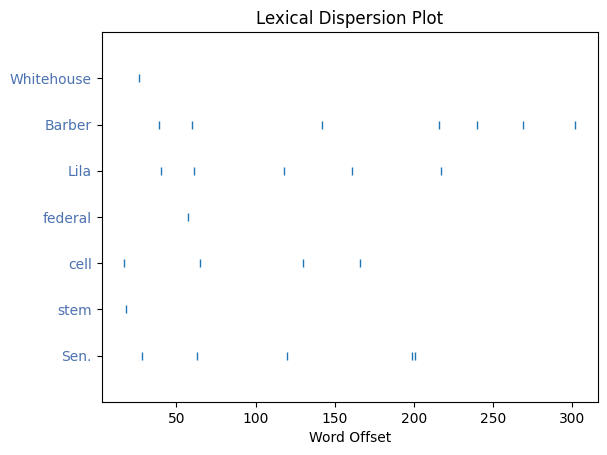

In [ ]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['Sen.','stem', 'cell', 'federal' ,'Lila', 'Barber', 'Whitehouse'])
sns.set() #Re-enabling seaborn

If we want to do an analysis of all the Whitehouse press releases we will first need to obtain them. By looking at the API we can see the the URL we want is [https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse](https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse), so we can create a function to scrape the individual files.

If you want to know more about downloading from APIs, refer back to the 1st notebook.

In [ ]:
def getGithubFiles(target, maxFiles = 100):
    #We are setting a max so our examples don't take too long to run
    #For converting to a DataFrame
    releasesDict = {
        'name' : [], #The name of the file
        'text' : [], #The text of the file, watch out for binary files
        'path' : [], #The path in the git repo to the file
        'html_url' : [], #The url to see the file on Github
        'download_url' : [], #The url to download the file
    }

    #Get the directory information from Github
    r = requests.get(target)
    filesLst = json.loads(r.text)

    for fileDict in filesLst[:maxFiles]:
        #These are provided by the directory
        releasesDict['name'].append(fileDict['name'])
        releasesDict['path'].append(fileDict['path'])
        releasesDict['html_url'].append(fileDict['html_url'])
        releasesDict['download_url'].append(fileDict['download_url'])

        #We need to download the text though
        text = requests.get(fileDict['download_url']).text
        releasesDict['text'].append(text)

    return pandas.DataFrame(releasesDict)

whReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse', maxFiles = 10)
whReleases[:5]

,name,text,path,html_url,download_url
0,10Apr2007Whitehouse123.txt,SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...,raw/Whitehouse/10Apr2007Whitehouse123.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
1,10Apr2008Whitehouse2.txt,SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...,raw/Whitehouse/10Apr2008Whitehouse2.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
2,10Apr2008Whitehouse3.txt,EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...,raw/Whitehouse/10Apr2008Whitehouse3.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
3,10Aug2007Whitehouse78.txt,R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...,raw/Whitehouse/10Aug2007Whitehouse78.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
4,10Jan2008Whitehouse35.txt,SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...,raw/Whitehouse/10Jan2008Whitehouse35.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...


If you are having trouble downloading the data uncomment this next cell

In [ ]:
whReleases = pandas.read_csv('../data/whReleases.csv')

Now we have all the texts in a DataFrame we can look at a few things.

First let's tokenize the texts with the same tokenizer as we used before. We will just save the tokens as a list for now; no need to convert to `Text`s.

In [ ]:
whReleases['tokenized_text'] = whReleases['text'].apply(lambda x: word_tokenize(x))

Now lets see how long each of the press releases is:

In [ ]:
whReleases['word_counts'] = whReleases['tokenized_text'].apply(lambda x: len(x))
whReleases['word_counts']

0    350
1    311
2    497
3    189
4    236
5    334
6    241
7    469
8    443
9    425
Name: word_counts, dtype: int64

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that input and interrogate a corpus relating to your anticipated final project. This could include one of the Davies corpora or some other you have constructed. Turn your text into an nltk `Text` object, and explore all of the features examined above, and others that relate to better understanding your corpus in relation to your research question. </font>

In [2]:
import requests
from bs4 import BeautifulSoup

def get_reviews(appid, params={'json': 1}):
    url = 'https://store.steampowered.com/appreviews/'
    response = requests.get(url=url + str(appid), params=params, headers={'User-Agent': 'Mozilla/5.0'})
    return response.json()

def get_n_reviews(appid, n=100):
    reviews = []
    cursor = '*'
    params = {
        'json': 1,
        'filter': 'all',
        'language': 'english',
        'day_range': 9223372036854775807,
        'review_type': 'all',
        'purchase_type': 'all'
    }

    for _ in range(5):
        params['cursor'] = cursor.encode()
        params['num_per_page'] = min(100, n)
        n -= 100

        response = get_reviews(appid, params)
        cursor = response['cursor']
        reviews += [review['review'] for review in response['reviews']]

        if len(response['reviews']) < 100:
            break

    return reviews

# Replace '413150' with the desired appid
appid = 413150
top_reviews = get_n_reviews(appid, n=500)  # 5 pages * 100 reviews per page
print(top_reviews)

['Fun and relaxing game. Always something to do and the updates keep it interesting. I am 72, have tried to play other games, but they cannot compete with Stardew, so I only play Stardew. Thank you, Concerned Ape.', "This game got me through a really dark place in my life. I lost my job, spouse, and home in less than a year. I would chop wood and fish when I couldn't find the energy to do anything else and fall asleep on the couch listening to the background music. I've put thousands of hours into Stardew Valley. The little successes I had were the catalyst I needed to think maybe I could have little successes again in life, too. Highly recommend. Thank you for making this game.", 'got depression? grow vegetable', 'I ask my crush to dance. She replies, "Ew, no."\n\n10/10 incredibily realistic game.', 'Stardew Valley, where you wana try the game for just 5 minutes but end up playing for 9 hours', 'helped me cure my league of legends addiction', 'this game let me live my wildest sexual f

In [3]:
import re
import pandas as pd

# Replace this with the actual list of links
steam_links = [
    'https://store.steampowered.com/app/1086940/Baldurs_Gate_3/',
    'https://store.steampowered.com/app/730/CounterStrike_2/',
    'https://store.steampowered.com/app/1966720/Lethal_Company/',
    'https://store.steampowered.com/app/1938090/Call_of_Duty/',
    'https://store.steampowered.com/app/1599340/Lost_Ark/',
    'https://store.steampowered.com/app/230410/Warframe/',
    'https://store.steampowered.com/app/1085660/Destiny_2/',
    'https://store.steampowered.com/app/2140330/Madden_NFL_24/',
    'https://store.steampowered.com/app/582010/Monster_Hunter_World/',
]

# Extract app ids and game names using regular expressions
app_id_to_game_name_mapping = {}
for link in steam_links:
    match = re.search(r'/app/(\d+)/([^/]+)/', link)
    if match:
        app_id = int(match.group(1))
        game_name = match.group(2).replace('_', ' ')
        app_id_to_game_name_mapping[app_id] = game_name

# Function to get reviews
def get_game_reviews_df(app_id_to_game_name_mapping):
    reviews_data = []

    for appid, game_name in app_id_to_game_name_mapping.items():
        reviews = get_n_reviews(appid, n=500)  # Adjust as needed

        # Clean reviews
        cleaned_reviews = [re.sub(r'[\n\r\t]', ' ', review) for review in reviews]

        reviews_data.append({'GameName': game_name, 'Reviews': cleaned_reviews})

    df = pd.DataFrame(reviews_data)
    return df

# Create DataFrame
reviews_df = get_game_reviews_df(app_id_to_game_name_mapping)

# Display the DataFrame
print(reviews_df)

               GameName                                            Reviews
0        Baldurs Gate 3  [You know that time when you're playing D&D an...
1       CounterStrike 2  [false game ban simulator, After 8 years playi...
2        Lethal Company  [The Steam trailer really doesn't do this game...
3          Call of Duty  [We're all aware of [b]Skill-Based Matchmaking...
4              Lost Ark  [Although it has been almost a month since I q...
5              Warframe  [[h1]My Impression[/h1] It's hard to write a p...
6             Destiny 2  [With almost 300 hours of Destiny 2 (D2) back ...
7         Madden NFL 24  [The "new" additions to franchise mode are nic...
8  Monster Hunter World  [I'm an older woman, and I find that this game...


In [4]:
import nltk
from nltk import word_tokenize
import pandas as pd

# Download the punkt resource for tokenization
nltk.download('punkt')

# Assuming you have already created the 'reviews_df' DataFrame

# Convert the 'Reviews' column to strings
reviews_df['Reviews'] = reviews_df['Reviews'].astype(str)

# Tokenize the reviews
reviews_df['TokenizedReviews'] = reviews_df['Reviews'].apply(lambda review: word_tokenize(review))

# Convert tokenized reviews to text
reviews_text = nltk.Text(reviews_df['TokenizedReviews'].sum())

# Create a ConcordanceIndex
reviews_index = nltk.text.ConcordanceIndex(reviews_text)

# Print concordance for 'Whitehouse'
reviews_index.print_concordance('fun')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Displaying 25 of 1083 matches:
polished game with unlimited hours of fun . Well done Larian Studios ! You can 
ngle one of them . - Combat is mostly fun and rewarding . It rewards a tactical
ches and freezes , this game is truly fun to play even though it is not finishe
 on easy mode and just relax and have fun : ) ' , `` Baldur 's Gate 3 is a remi
ou pickpocket the boss because it ’ s fun , and tells you they got nowhere to b
pay attention , there is nothing more fun than examining an enemy , determining
e best way possible . They\ 're [ b ] fun [ /b ] to explore and find routes thr
ecific spell . It\ 's brilliant , and fun , and the best aspect of the game by 
ttempt at deconstruction . It\ 's all fun if you go with it ; just keep it in m
off to explore anyway , but in a more fun way . Act 3 is ... huge . It\ 's prob
 ( and activity feed ) was especially fun because everyone had a totally differ
sed combat . But , BG3 makes it quite fun with heavy emphasis on their story . 
. ' , 'yo

In [5]:
reviews_df['ReviewCount'] = reviews_df['Reviews'].apply(len)
reviews_df['ReviewCount']

0    491678
1    187798
2    171414
3    285533
4    633639
5    623663
6    490731
7    166919
8    538111
Name: ReviewCount, dtype: int64

In [6]:
import nltk

# Assuming you have already created the 'reviews_df' DataFrame

# Convert the 'Reviews' column to strings
reviews_df['Reviews'] = reviews_df['Reviews'].astype(str)

# Tokenize the reviews
reviews_df['TokenizedReviews'] = reviews_df['Reviews'].apply(lambda review: word_tokenize(review))

# Convert tokenized reviews to text
reviews_text = nltk.Text(reviews_df['TokenizedReviews'].sum())

# Find common contexts for the words 'friend'
reviews_text.common_contexts(['explore'])

to_and to_, to_. to_the to_( to_all to_every and_the can_the you_,
to_in ,_everything to_various and_in that_one to_anyway to_just go_.
you_carefully to_with


In [7]:
import nltk

# Assuming you have already created the 'reviews_df' DataFrame

# Convert the 'Reviews' column to strings
reviews_df['Reviews'] = reviews_df['Reviews'].astype(str)

# Tokenize the reviews
reviews_df['TokenizedReviews'] = reviews_df['Reviews'].apply(lambda review: word_tokenize(review))

# Convert tokenized reviews to text
reviews_text = nltk.Text(reviews_df['TokenizedReviews'].sum())

# Create a ConcordanceIndex
reviews_index = nltk.text.ConcordanceIndex(reviews_text)

# Find the count of 'win'
win_count = len(reviews_index.offsets('win'))

# Find the count of 'lose'
lose_count = len(reviews_index.offsets('lose'))

print(f"Count of 'win': {win_count}")
print(f"Count of 'lose': {lose_count}")

Count of 'win': 122
Count of 'lose': 95


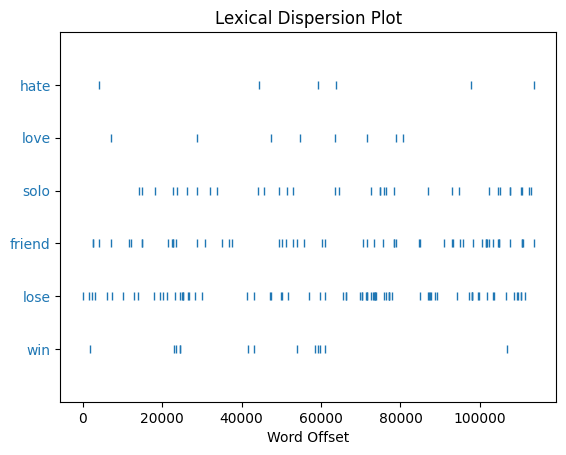

In [8]:
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

# Assuming you have already created the 'reviews_df' DataFrame

# Subset reviews_df to the 8th row
selected_row = reviews_df.iloc[8:9].copy()  # Make a copy to avoid SettingWithCopyWarning

# Convert the 'Reviews' column to strings
selected_row.loc[:, 'Reviews'] = selected_row['Reviews'].astype(str)

# Tokenize the reviews
selected_row.loc[:, 'TokenizedReviews'] = selected_row['Reviews'].apply(lambda review: word_tokenize(review))

# Convert tokenized reviews to text
reviews_text = nltk.Text(selected_row['TokenizedReviews'].sum())

# Create a dispersion plot for specified words
sns.reset_orig()  # Disable Seaborn temporarily
reviews_text.dispersion_plot(['win', 'lose', 'friend', 'solo', 'love', 'hate'])
plt.show()
sns.set()  # Re-enable Seaborn

In [9]:
import nltk

# Download the vader_lexicon resource
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [10]:
#sentiment analysis
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

# Assuming you have already created the 'reviews_df' DataFrame with 'GameName' and 'Reviews' columns

# Convert the 'Reviews' column to strings
reviews_df['Reviews'] = reviews_df['Reviews'].astype(str)

# Initialize the SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Calculate sentiment scores for each review
reviews_df['SentimentScores'] = reviews_df['Reviews'].apply(lambda review: sid.polarity_scores(review)['compound'])

# Aggregate sentiment scores for each game
game_sentiments = reviews_df.groupby('GameName')['SentimentScores'].mean().reset_index()

# Display the aggregated sentiment scores for each game
print(game_sentiments)

               GameName  SentimentScores
0        Baldurs Gate 3           1.0000
1          Call of Duty           0.9998
2       CounterStrike 2           1.0000
3             Destiny 2           1.0000
4        Lethal Company           1.0000
5              Lost Ark           1.0000
6         Madden NFL 24           1.0000
7  Monster Hunter World           1.0000
8              Warframe           1.0000


In [11]:
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
import nltk

# Download the required resource
nltk.download('averaged_perceptron_tagger')


# Assuming you have already created the 'reviews_df' DataFrame

# Convert the 'Reviews' column to strings
reviews_df['Reviews'] = reviews_df['Reviews'].astype(str)

# Tokenize and tag the reviews with part-of-speech
reviews_df['TokenizedReviews'] = reviews_df['Reviews'].apply(lambda review: pos_tag(word_tokenize(review)))

# Function to filter out non-real words based on WordNet POS tags
def is_real_word(tag):
    return tag.startswith('N') or tag.startswith('V') or tag.startswith('R') or tag.startswith('J')

# Filter out non-real words
reviews_df['RealWords'] = reviews_df['TokenizedReviews'].apply(lambda review: [(word, tag) for word, tag in review if is_real_word(tag)])

# Concatenate all tokenized reviews into a single list of real words
all_real_words = [word for review in reviews_df['RealWords'] for word, _ in review]

# Create a BigramCollocationFinder
bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(all_real_words)

# Apply PMI measure and get the top 10 collocations
collocations = finder.nbest(bigram_measures.pmi, 10)

# Display the top collocations
print(collocations)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


[("'Boombox", "'Screaming"), ("'CROSS-SAVE", 'WORKED'), ("'Easy", 'Peasy'), ("'Edit", 'Mar'), ("'Elphant", "'hoarding"), ("'Flashbang", 'Day\\'), ("'Fuck", "'Anything"), ("'Huge", 'swaths'), ("'KARLACH", 'ENJOYERS'), ("'May", 'fortify')]


# Filtering and normalizing text

As we want to start comparing the different releases we may choose to do a bit of filtering and normalizing that will allow us to focus on what we most care about. We can first make all of the words lower case, then drop the non-word tokens. Next, we can remove some 'stop words', stem the remaining words to remove suffixes, prefixes and (in some languages) infixes, or lemmatize tokens by intelligently grouping inflected or variant forms of the same word (e.g., with a stemmer and a dictionary).

To begin this process, we will first define a function to work over the tokenized lists, then another to add normalized tokens to a new column.

We will be using spaCy's built in stop words identifying capacity. When we run text through spaCy's language pipeline, it automatically tags it as a stop word.

We can remove these stopwords from the analysis by fiat, but we could also take a more principled approach by looking at the frequency distribution of words and selecting a specific cut-off associated with the preservation of 'meaningful words' identified upon inspection. Alternatively, we could automatically set a cut-off by rule, such as removal of all words more frequent then the most frequent verb, or the most frequent noun (not pronoun), or some term of central interest.

In [ ]:
countsDict = {}
for word in whReleases['tokenized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:20]

We can look at this and pick the cutoff, often at the first noun. So we will cut all words before `'Whitehouse'`.

In [ ]:
#The stop list is then all words that occur before the first noun
stop_words_freq = []
for word, count in word_counts:
    if word == 'Whitehouse':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq

['the', 'of', 'to', 'and', 'in', 'a', "'s", 'that', 'our', 'for', 'on', 'is']

If we did have any extra words to add as stop words apart from those normally considered as stop words, we would add it to our stop words by passing it to the normalize tokens method.

Now we can create our function to normalize the tokens

In [ ]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list])

    doc = nlp(word_list.lower())

    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [ ]:
whReleases['normalized_tokens'] = whReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

whReleases['normalized_tokens_count'] = whReleases['normalized_tokens'].apply(lambda x: len(x))

whReleases

,name,text,path,html_url,download_url,tokenized_text,word_counts,normalized_tokens,normalized_tokens_count
0,10Apr2007Whitehouse123.txt,SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...,raw/Whitehouse/10Apr2007Whitehouse123.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SEN, WHITEHOUSE, SHARES, WESTERLY, GIRL, 'S, ...",350,"[sen, whitehouse, share, westerly, girl, story...",224
1,10Apr2008Whitehouse2.txt,SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...,raw/Whitehouse/10Apr2008Whitehouse2.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SEN, WHITEHOUSE, SAYS, PRESIDENT, BUSH, MUST,...",311,"[sen, whitehouse, say, president, bush, begin,...",159
2,10Apr2008Whitehouse3.txt,EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...,raw/Whitehouse/10Apr2008Whitehouse3.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[EPA, MUST, REVIEW, LEGAL, PROCESS, TO, ROOT, ...",497,"[epa, review, legal, process, root, political,...",298
3,10Aug2007Whitehouse78.txt,R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...,raw/Whitehouse/10Aug2007Whitehouse78.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[R.I., SENATORS, PRAISE, SEN, DENIAL, OF, LNG,...",189,"[r.i, senator, praise, sen, denial, lng, facil...",116
4,10Jan2008Whitehouse35.txt,SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...,raw/Whitehouse/10Jan2008Whitehouse35.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SEN, WHITEHOUSE, COMMENTS, ON, ONE, YEAR, ANN...",236,"[sen, whitehouse, comment, year, anniversary, ...",125
5,10Mar2008Whitehouse8.txt,"SENS. REED, WHITEHOUSE WELCOME RHODE ISLAND ST...",raw/Whitehouse/10Mar2008Whitehouse8.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SENS, REED, WHITEHOUSE, WELCOME, RHODE, ISLAN...",334,"[sen, reed, whitehouse, welcome, rhode, island...",197
6,10Sep2007Whitehouse72.txt,REP. WHITEHOUSE ISSUES STATEMENT ON GEN. PETRA...,raw/Whitehouse/10Sep2007Whitehouse72.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[REP, WHITEHOUSE, ISSUES, STATEMENT, ON, GEN, ...",241,"[rep, whitehouse, issue, statement, gen, petra...",118
7,11Apr2007Whitehouse122.txt,SEN. WHITEHOUSE URGES BUSH FOR NEW DIRECTION I...,raw/Whitehouse/11Apr2007Whitehouse122.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SEN, WHITEHOUSE, URGES, BUSH, FOR, NEW, DIREC...",469,"[sen, whitehouse, urge, bush, new, direction, ...",249
8,11Jan2007Whitehouse161.txt,"SENS. REED, WHITEHOUSE URGE PORTUGAL TO RECONS...",raw/Whitehouse/11Jan2007Whitehouse161.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SENS, REED, WHITEHOUSE, URGE, PORTUGAL, TO, R...",443,"[sen, reed, whitehouse, urge, portugal, recons...",237
9,11Mar2008Whitehouse7.txt,WHITEHOUSE UNVEILS 'BUSH DEBT': $7.7 TRILLION ...,raw/Whitehouse/11Mar2008Whitehouse7.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[WHITEHOUSE, UNVEILS, BUSH, DEBT, $, 7.7, TRIL...",425,"[whitehouse, unveil, bush, debt, $, foregone, ...",241


You can see that in the final step of normalizing, we add the lemmatized form of the word. spaCy's built in lemmatizer does this (https://spacy.io/api/lemmatizer). Lemmatization can be thought of as finding the root or the base of the word after removing inflections and other variations of words. Another possible way of finding the roots of words is using NLTK's porting or stemming functionalities, but we will not be getting into them.

Now that it is cleaned we start analyzing the dataset. We can start by finding frequency distributions for the dataset. Lets start looking at all the press releases together. The [`ConditionalFreqDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) class reads in an iterable of tuples, the first element is the condition and the second the focal word. For starters, we will use word lengths as the conditions, but tags or clusters will provide more useful results.

In [ ]:
#.sum() adds together the lists from each row into a single list
whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in whReleases['normalized_tokens'].sum()))

#print the number of words
print(whcfdist.N())

1964


From this we can lookup the distributions of different word lengths

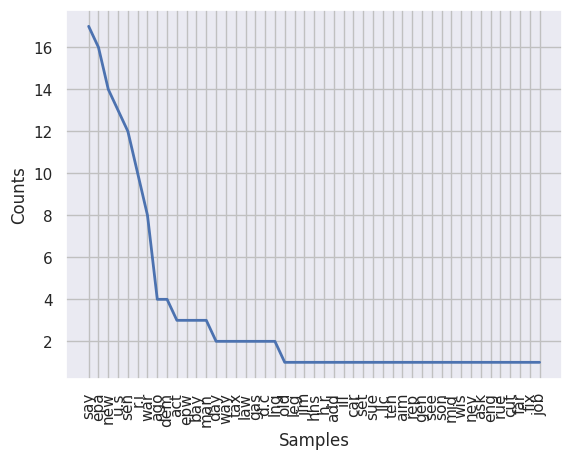

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
whcfdist[3].plot()

We can also create a Conditional Probability Distribution or [`ConditionalProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) from the `ConditionalFreqDist`. To do this, however, we need a model for the probability distribution. A simple model is [`ELEProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ELEProbDist) which gives the expected likelihood estimate for the probability distribution of the experiment used to generate the observed frequency distribution.

In [ ]:
whcpdist = nltk.ConditionalProbDist(whcfdist, nltk.ELEProbDist)

#print the most common 2 letter word
print(whcpdist[2].max())

#And its probability
print(whcpdist[2].prob(whcpdist[2].max()))

ri
0.25


Length is one feature of a word, but there are many more important features we care about. Another critical feature is a word's role in the sentence, or its part of speech (POS).

The method below works similarly to ```nltk.pos_text```, and can work with the conditional frequency distributions it provides.

In [ ]:
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [ ]:
whReleases['normalized_tokens_POS'] = [spacy_pos(t) for t in whReleases['text']]

This gives us a new column with the part of speech as a short initialism and the word in a tuple, exactly how the `nltk.ConditionalFreqDist()` function wants them. We can now construct another conditional frequency distribution.

In [ ]:
whcfdist_WordtoPOS = nltk.ConditionalFreqDist(whReleases['normalized_tokens_POS'].sum())
list(whcfdist_WordtoPOS.items())[:10]

[('sen', FreqDist({'NNP': 9})),
 ('.', FreqDist({'.': 126, 'NNP': 39, 'NN': 1})),
 ('whitehouse', FreqDist({'NN': 21, 'NNP': 19})),
 ('shares', FreqDist({'NNS': 1})),
 ('westerly', FreqDist({'RB': 2})),
 ('girl', FreqDist({'NN': 2})),
 ("'s", FreqDist({'POS': 47, 'VBZ': 5})),
 ('story', FreqDist({'NN': 2})),
 ('in', FreqDist({'IN': 72})),
 ('push', FreqDist({'NN': 1}))]

This gives the frequency of each word as each part of speech...which can be uninformative and boring. What we want is the converse; the frequency of each part of speech for each word.

In [ ]:
whcfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in whReleases['normalized_tokens_POS'].sum())

We can now identify and collect all of the superlative adjectives

In [ ]:
whcfdist_POStoWord['JJ']

FreqDist({'american': 17, 'new': 11, 'portuguese': 9, 'political': 8, 'federal': 6, 'clear': 5, 'general': 5, 'potential': 5, 'fiscal': 5, 'last': 4, ...})

Or look at the most common nouns

In [ ]:
whcfdist_POStoWord['NN'].most_common(5)

[('whitehouse', 21),
 ('rhode', 19),
 ('island', 15),
 ('today', 15),
 ('stem', 12)]

Or plot the base form verbs against their number of occurrences

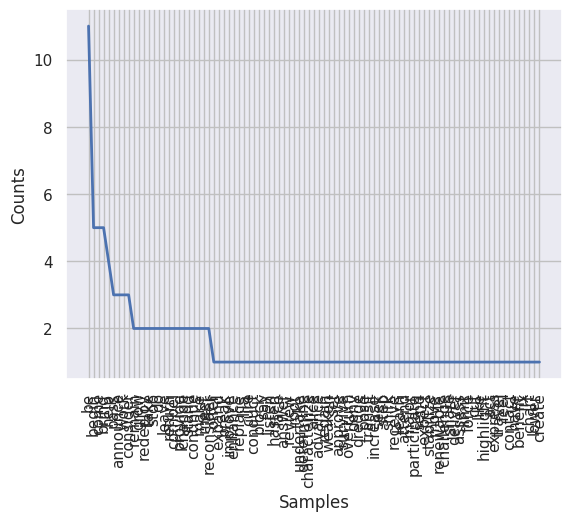

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
whcfdist_POStoWord['VB'].plot()

We can then do a similar analysis of the word probabilities

In [ ]:
whcpdist_POStoWord = nltk.ConditionalProbDist(whcfdist_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(whcpdist_POStoWord['NN'].max())

#And its probability
print(whcpdist_POStoWord['NN'].prob(whcpdist_POStoWord['NN'].max()))

whitehouse
0.025190392501464556


We can even create a...wait for it...*WORD CLOUD* or Wordl to gaze at and draw mystical, approximate inferences about important nouns and verbs in our corpus:

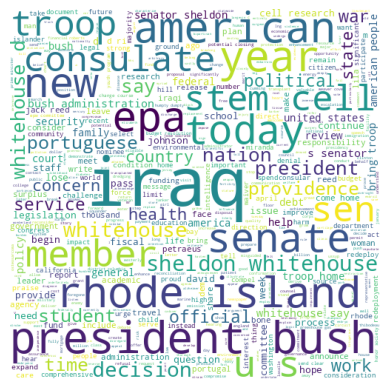

In [ ]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(whReleases['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("whitehouse_word_cloud.pdf", format = 'pdf')

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that filter, stem and lemmatize the tokens in your corpus, and then creates plots (with titles and labels) that map the word frequency distribution, word probability distribution, and at least two conditional probability distributions that help us better understand the social and cultural game underlying the production of your corpus. Create a wordl of words (or normalized words) and add a few vague comments about what mysteries are revealed through it.</font>

In [12]:
# Assuming you have already created the 'reviews_df' DataFrame with 'Reviews' column

# Function to remove specific characters from reviews
def remove_characters(review, characters_to_remove):
    return [word.replace(characters_to_remove, '') for word in review]

# Remove "⣿" from the 'Reviews' column
reviews_df['Reviews'] = reviews_df['Reviews'].apply(lambda review: remove_characters(review, '⣿'))

In [13]:
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Replace this with the actual list of links
steam_links = [
    'https://store.steampowered.com/app/1086940/Baldurs_Gate_3/',
    'https://store.steampowered.com/app/730/CounterStrike_2/',
    'https://store.steampowered.com/app/1966720/Lethal_Company/',
    'https://store.steampowered.com/app/1938090/Call_of_Duty/',
    'https://store.steampowered.com/app/1599340/Lost_Ark/',
    'https://store.steampowered.com/app/230410/Warframe/',
    'https://store.steampowered.com/app/1085660/Destiny_2/',
    'https://store.steampowered.com/app/2140330/Madden_NFL_24/',
    'https://store.steampowered.com/app/582010/Monster_Hunter_World/',
]

# Extract app ids and game names using regular expressions
app_id_to_game_name_mapping = {}
for link in steam_links:
    match = re.search(r'/app/(\d+)/([^/]+)/', link)
    if match:
        app_id = int(match.group(1))
        game_name = match.group(2).replace('_', ' ')
        app_id_to_game_name_mapping[app_id] = game_name

# Function to get reviews
def get_game_reviews_df(app_id_to_game_name_mapping):
    reviews_data = []

    for appid, game_name in app_id_to_game_name_mapping.items():
        reviews = get_n_reviews(appid, n=500)  # Adjust as needed
        reviews_data.append({'GameName': game_name, 'Reviews': reviews})

    df = pd.DataFrame(reviews_data)
    return df

# Create DataFrame
reviews_df = get_game_reviews_df(app_id_to_game_name_mapping)

# Function to normalize tokens
def normalize_tokens(text):
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

# Normalize tokens in the 'Reviews' column
reviews_df['NormalizedReviews'] = reviews_df['Reviews'].apply(lambda reviews: [normalize_tokens(review) for review in reviews])

# Display the DataFrame
print(reviews_df)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


               GameName                                            Reviews  \
0        Baldurs Gate 3  [You know that time when you're playing D&D an...   
1       CounterStrike 2  [false game ban simulator, After 8 years playi...   
2        Lethal Company  [The Steam trailer really doesn't do this game...   
3          Call of Duty  [We're all aware of [b]Skill-Based Matchmaking...   
4              Lost Ark  [Although it has been almost a month since I q...   
5              Warframe  [[h1]My Impression[/h1]\nIt's hard to write a ...   
6             Destiny 2  [With almost 300 hours of Destiny 2 (D2) back ...   
7         Madden NFL 24  [The "new" additions to franchise mode are nic...   
8  Monster Hunter World  [I'm an older woman, and I find that this game...   

                                   NormalizedReviews  
0  [[know, time, youre, playing, dd, think, man, ...  
1  [[false, game, ban, simulator], [years, playin...  
2  [[steam, trailer, really, doesnt, game, justic...  

In [14]:
import spacy

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Function to lemmatize tokens using spaCy
def lemmatize_tokens(tokens):
    # Join tokens into a string
    text = ' '.join(tokens)
    # Process the text with spaCy
    doc = nlp(text)
    # Extract lemmatized forms
    lemmatized_tokens = [token.lemma_ for token in doc]
    return lemmatized_tokens

# Apply lemmatization to the 'NormalizedReviews' column
reviews_df['LemmatizedReviews'] = reviews_df['NormalizedReviews'].apply(lambda reviews: [lemmatize_tokens(review) for review in reviews])

# Display the DataFrame
print(reviews_df)

               GameName                                            Reviews  \
0        Baldurs Gate 3  [You know that time when you're playing D&D an...   
1       CounterStrike 2  [false game ban simulator, After 8 years playi...   
2        Lethal Company  [The Steam trailer really doesn't do this game...   
3          Call of Duty  [We're all aware of [b]Skill-Based Matchmaking...   
4              Lost Ark  [Although it has been almost a month since I q...   
5              Warframe  [[h1]My Impression[/h1]\nIt's hard to write a ...   
6             Destiny 2  [With almost 300 hours of Destiny 2 (D2) back ...   
7         Madden NFL 24  [The "new" additions to franchise mode are nic...   
8  Monster Hunter World  [I'm an older woman, and I find that this game...   

                                   NormalizedReviews  \
0  [[know, time, youre, playing, dd, think, man, ...   
1  [[false, game, ban, simulator], [years, playin...   
2  [[steam, trailer, really, doesnt, game, justic..

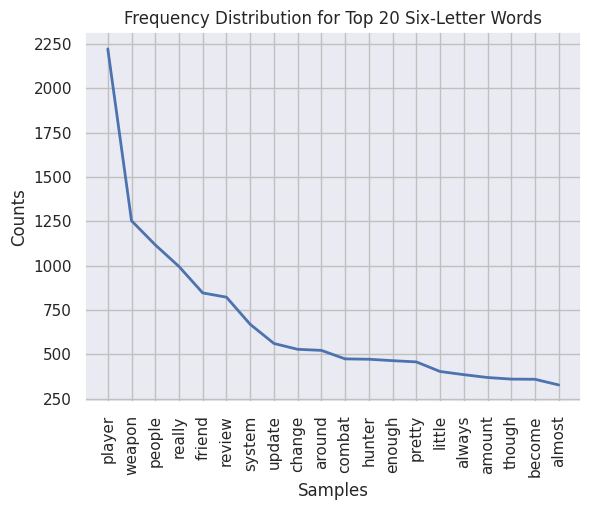

<Axes: title={'center': 'Frequency Distribution for Top 20 Six-Letter Words'}, xlabel='Samples', ylabel='Counts'>

In [15]:
from itertools import chain

# Flatten the list of lemmatized reviews
flat_lemmatized_reviews = list(chain.from_iterable(chain.from_iterable(reviews_df['LemmatizedReviews'])))

# Create Frequency Distribution for six-letter words
six_letter_words_freq = nltk.FreqDist(word for word in flat_lemmatized_reviews if len(word) == 6)

# Plot the frequency distribution for the top 20 six-letter words
six_letter_words_freq.plot(20, title='Frequency Distribution for Top 20 Six-Letter Words')

In [16]:
import spacy
from collections import Counter

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Function to get POS tags for a text
def get_pos_tags(text):
    doc = nlp(text)
    return [token.pos_ for token in doc]

# Apply the function to each review in the 'Reviews' column
reviews_df['POS_tags'] = reviews_df['Reviews'].apply(lambda reviews: [get_pos_tags(review) for review in reviews])

# Display the DataFrame with POS tags
print(reviews_df[['GameName', 'Reviews', 'POS_tags']])

               GameName                                            Reviews  \
0        Baldurs Gate 3  [You know that time when you're playing D&D an...   
1       CounterStrike 2  [false game ban simulator, After 8 years playi...   
2        Lethal Company  [The Steam trailer really doesn't do this game...   
3          Call of Duty  [We're all aware of [b]Skill-Based Matchmaking...   
4              Lost Ark  [Although it has been almost a month since I q...   
5              Warframe  [[h1]My Impression[/h1]\nIt's hard to write a ...   
6             Destiny 2  [With almost 300 hours of Destiny 2 (D2) back ...   
7         Madden NFL 24  [The "new" additions to franchise mode are nic...   
8  Monster Hunter World  [I'm an older woman, and I find that this game...   

                                            POS_tags  
0  [[PRON, VERB, DET, NOUN, SCONJ, PRON, AUX, VER...  
1  [[ADJ, NOUN, NOUN, NOUN], [ADP, NUM, NOUN, VER...  
2  [[DET, PROPN, NOUN, ADV, AUX, PART, VERB, DET,...  

In [17]:
import nltk

# Combine all POS tags into a single list
all_pos_tags = [tag for sublist in reviews_df['POS_tags'].sum() for tag in sublist]

# Create FreqDist for POS tags
pos_freq_dist = nltk.FreqDist(all_pos_tags)

# Print the most common POS
most_common_pos = pos_freq_dist.max()

# Print the most common POS and its frequency
print(f"Most Common POS: {most_common_pos}")
print(f"Frequency: {pos_freq_dist[most_common_pos]}")

Most Common POS: NOUN
Frequency: 132677


In [24]:
import pandas as pd
import nltk

# Flatten the list of lists in the 'Reviews' column
all_reviews = [word for review_list in reviews_df['Reviews'] for review in review_list for word in review.split()]

# Create a new dataframe with each word in a separate row
exploded_df = pd.DataFrame({'Word': all_reviews})

# Drop NaN values in the 'Word' column
exploded_df = exploded_df.dropna(subset=['Word'])

# Use NLTK to assign POS tags to each word
exploded_df['POS_tag'] = exploded_df['Word'].apply(lambda word: nltk.pos_tag([word])[0][1])

# Display the resulting DataFrame
print(exploded_df.head())

   Word POS_tag
0   You     PRP
1  know      VB
2  that      IN
3  time      NN
4  when     WRB


In [27]:
import nltk

# Function to get POS tags using NLTK
def get_pos_tags_nltk(text):
    tokens = nltk.word_tokenize(text)
    return nltk.pos_tag(tokens)

# Apply the function to the 'Reviews' column
exploded_df['POS_tag_nltk'] = exploded_df['Word'].apply(get_pos_tags_nltk)

# Function to check if the POS tag is a verb
def is_verb(pos_tag):
    return 'yes' if pos_tag.startswith('VB') else 'no'

# Create a new column 'Verb' based on the 'POS_tag_nltk' column
exploded_df['Verb'] = exploded_df['POS_tag_nltk'].apply(lambda pos_tag: is_verb(pos_tag[0][1] if pos_tag else 'no'))

# Display the resulting DataFrame
print(exploded_df[['Word', 'POS_tag_nltk', 'Verb']].head())

   Word   POS_tag_nltk Verb
0   You   [(You, PRP)]   no
1  know   [(know, VB)]  yes
2  that   [(that, IN)]   no
3  time   [(time, NN)]   no
4  when  [(when, WRB)]   no


In [29]:
# Subset the data where Verb is 'yes'
verb_yes_df = exploded_df[exploded_df['Verb'] == 'yes']

# Combine all words into a single list
all_words_verb_yes = verb_yes_df['Word'].tolist()

# Create Frequency Distribution
word_freq_verb_yes = nltk.FreqDist(all_words_verb_yes)

# Find the most common word
most_common_word_verb_yes = word_freq_verb_yes.max()

# Print the most common word
print(f"Most Common Word (Verb = 'yes'): {most_common_word_verb_yes}")
print(f"Frequency: {word_freq_verb_yes[most_common_word_verb_yes]}")

Most Common Word (Verb = 'yes'): is
Frequency: 9217


In [33]:
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords data
nltk.download('stopwords')

# List of articles to remove
articles_to_remove = ["is", "are", "and", "the", "a", "an", "to", "in", "of", "with", "on", "for", "at", "by"]

# Remove articles from the Word column
exploded_df['Word_no_articles'] = exploded_df['Word'].apply(lambda word: word.lower() if word.lower() not in articles_to_remove else None)

# Drop rows with None values in Word_no_articles
verb_yes_no_articles_df = exploded_df.dropna(subset=['Word_no_articles'])

# Remove common stopwords using NLTK
stop_words = set(stopwords.words('english'))
verb_yes_no_articles_df['Word_no_stopwords'] = verb_yes_no_articles_df['Word_no_articles'].apply(lambda word: word if word not in stop_words else None)

# Drop rows with None values in Word_no_stopwords
verb_yes_no_articles_df = verb_yes_no_articles_df.dropna(subset=['Word_no_stopwords'])

# Subset the data where Verb is 'yes' and no articles and no stopwords
verb_yes_no_articles_df = verb_yes_no_articles_df[verb_yes_no_articles_df['Verb'] == 'yes']

# Combine all words into a single list
all_words_verb_yes_no_articles = verb_yes_no_articles_df['Word_no_stopwords'].tolist()

# Create Frequency Distribution
word_freq_verb_yes_no_articles = nltk.FreqDist(all_words_verb_yes_no_articles)

# Find the most common word
most_common_word_verb_yes_no_articles = word_freq_verb_yes_no_articles.max()

# Print the most common word
print(f"Most Common Word (Verb = 'yes', no articles, no stopwords): {most_common_word_verb_yes_no_articles}")
print(f"Frequency: {word_freq_verb_yes_no_articles[most_common_word_verb_yes_no_articles]}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-33-8667c1a62b35>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verb_yes_no_articles_df['Word_no_stopwords'] = verb_yes_no_articles_df['Word_no_articles'].apply(lambda word: word if word not in stop_words else None)


Most Common Word (Verb = 'yes', no articles, no stopwords): get
Frequency: 2316


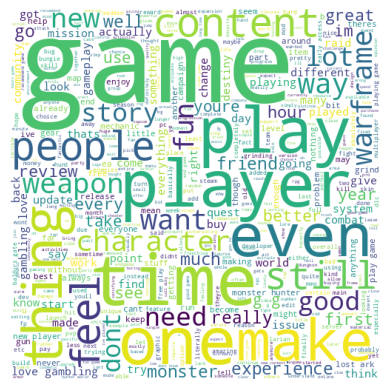

In [32]:
import wordcloud
import matplotlib.pyplot as plt

# Combine all normalized tokens into a single list
all_normalized_tokens = [token for sublist in reviews_df['NormalizedReviews'] for token_list in sublist for token in token_list]

# Join the normalized tokens into a single string for WordCloud
normalized_text = ' '.join(all_normalized_tokens)

# Create a WordCloud object
wc = wordcloud.WordCloud(background_color="white", max_words=500, width=1000, height=1000, mode='RGBA', scale=0.5).generate(normalized_text)

# Display the WordCloud
plt.imshow(wc)
plt.axis("off")
plt.show()

**There are unsurprising words like "play" and "game" which are very prominent. However, there are others that are more implicative, like "feel" suggesting some degree of acknowledged introspection/opinionation. There is a lot of focus on there being cool characters and weapons, which is good to know. Presumably the time it takes to beat the game and the amount of content are important. Lastly, it seems the story and cooperative elements (seeing as "friend" is a somewhat prominent word) are crucial to "fun", another prominent word.**

## Davies Corpora

Now that we have our basic cleaning down, we can arrange our Davies Corpora. Let us try this with the movies corpora we have already loaded.

We'll use a smaller corpus of a 1000 movies for this demonstration.

In [ ]:
zfile = zipfile.ZipFile(corpus_name + "/sources_movies.zip")
source = []

In [ ]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [ ]:
source[0:20]

[b'textID\tfileID\t#words\tgenre\tyear\tlanguage(s)\tcountry\timdb\ttitle\r\n',
 b'-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\r\n',
 b'\r\n',
 b'290635\t3547424\t4722\tShort, Musical\t1930\tUK\tEnglish\t0290635\tGoodbye to All That\r\n',
 b'21165\t6332374\t10220\tCrime, Mystery, Thriller\t1930\tUK\tEnglish\t0021165\tMurder!\r\n',
 b'21191\t6013789\t5281\tDrama, Romance\t1930\tUSA\tEnglish\t0021191\tA Notorious Affair\r\n',
 b'20620\t3660608\t6724\tBiography, Drama, History\t1930\tUSA\tEnglish\t0020620\tAbraham Lincoln\r\n',
 b'20629\t60053\t9552\tDrama, War\t1930\tUSA\tEnglish, French, German, Latin\t0020629\tAll Quiet on the Western Front\r\n',
 b'20640\t6850720\t13862\tComedy, Musical\t1930\tUSA\tEnglish\t0020640\tAnimal Crackers\r\n',
 b'20641\t176501\t11140\tDrama, Romance\t1930\tUSA\tEnglish\t0020641\tAnna Christie\r\n',
 b'20643\t3603861\t1748\tComedy, Short\t1930\tUSA\tEnglish\t0020643\tAnother Fine Mess\r\n',
 b'20670\t4159455\t6966\tComedy, Musical\t1930\tUS

It looks dirty because the file is encoded as bytes, but we can certainly see the information there. The file id is also present in the original raw text data: as the first "word". Look back at the normalized/tokenized words to confirm that. We're going to use this to create a dataframe with: Fileid, movie name, genre, year, and country.

It is advised that you run a similar check of the source file before you do other extraction.

First, let us create a dictionary mapping file-id to all the text. Each movie will be mapped to a list of the tokenized words.

In this example, I only use it to load 100 movies. You can comment this out or increase/decrease the number as you see fit.

Note that in the following cells, we make use of the `lucem_illud` package's `word_tokenize` function. You can see that function on line 70 of [processing.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/processing.py), and we provide the code here for transparency. Since we put this folder in our helper package, you won't need to define this function every time you want to use it; you just `import lucem_illud`!

In [ ]:
# processing.py calls a spacy model called "en" (and sometimes called "en_core_web_sm") so we load that first.
try:
    nlp = spacy.load("en")
except OSError:
    nlp = spacy.load("en_core_web_sm")


#Here is the function from lucem_illud/lucem_illud/processing.py
def word_tokenize(word_list, model=nlp, MAX_LEN=1500000):

    tokenized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list])
    # since we're only tokenizing, I remove RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list, disable=["parser", "tagger", "ner"])

    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [ ]:
movie_texts = {}

In [ ]:
for files in movie_raw:
    if len(movie_texts) > 100:
        break
    movies = clean_raw_text(movie_raw[files][1:])
    for movie in movies:
        # We can run the following line of code with or without `lucem_illud.`, using the package or our code 2 cells above.
        txts = lucem_illud.word_tokenize(movie)
        try:
            movie_texts[txts[0][2:]] = txts[1:]
        except IndexError:
            continue

In [ ]:
import pandas as pd

In [ ]:
movie_df = pd.DataFrame(columns=["Movie Name", "Genre", "Year", "Country", "Tokenized Texts"])

In [ ]:
for movie in source[3:]:
    try:
        tid, fileid, total_words, genre, year, lang, country, imdb, title = movie.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    try:
        movie_df.loc[fileid.strip()] = [title.strip(), genre.strip(), year.strip(), country.strip(), movie_texts[fileid.strip()]]
    except KeyError:
        continue

In [ ]:
movie_df.head()

,Movie Name,Genre,Year,Country,Tokenized Texts
3660608,Abraham Lincoln,"Biography, Drama, History",1930,English,"[Tom, Lincoln, It, 's, a, comin, Boy, or, gal,..."
6930684,It's Tough to Be Famous,"Comedy, Drama",1932,English,"[music_continues, music_continues, music_ends,..."
6930686,The Midnight Lady,"Crime, Drama, Mystery",1932,English,"[@dramatic_orchestral_music, Woman, What, do, ..."
5848404,Young America,Drama,1932,English,"[Come, on, Come, on, Hurry, up, Hurry, up, Com..."
4193921,Blood Money,"Drama, Film-Noir, Romance",1933,English,"[This, program, has, come, to, you, from, Bill..."


# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. We will be using the in-built spaCy pos-tagging.

https://spacy.io/usage/linguistic-features

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

spaCy pos-tags word as we run it through the english language model. A small example:

In [ ]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")


In [ ]:
for token in sent:
    print(token.text, token.pos_, token.tag_)

Tom PROPN NNP
went VERB VBD
to ADP IN
IKEA NOUN NN
to PART TO
get VERB VB
some PRON DT
of ADP IN
those DET DT
delicious ADJ JJ
Swedish ADJ JJ
meatballs NOUN NNS
. PUNCT .


This looks quite good. Now we will try POS tagging with a somewhat larger corpus. We consider a few of the top posts from the reddit data we used last week.

In [ ]:
redditDF = pandas.read_csv('../data/reddit.csv')


Grabbing the 10 highest scoring posts and tokenizing the sentences. Once again, notice that we aren't going to do any kind of stemming this week (although *semantic* normalization may be performed where we translate synonyms into the same focal word). Here, we will use sentences tokenized by spaCy. Like before, these methods can also be found in `lucem_illud`.



In [ ]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.text.strip() for sent in doc.sents]
    return sentences

In [ ]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


,Unnamed: 0,author,over_18,score,subreddit,text,title,url,sentences
9,8,brenkelieshere,False,9448,Tales From Tech Support,"Last year, Help Desk got a call from a user co...",How to fix a laptop that won't boot in under a...,https://www.reddit.com/r/talesfromtechsupport/...,"[[Last, year, Help, Desk, got, a, call, from, ..."
8,7,Bombadils,False,10528,Tales From Tech Support,First post in quite some time! I work at a loc...,"OK, now the password is 'D35p41r'",https://www.reddit.com/r/talesfromtechsupport/...,"[[First, post, in, quite, some, time], [I, wor..."
7,1200,whenlifegivesyoushit,False,11003,Relationships,[Original Post](https://www.reddit.com/r/relat...,[UPDATE]My [26 F] with my husband [29 M] 1 yea...,https://www.reddit.com/r/relationships/comment...,"[[Original, Post](https://www.reddit.com, r, r..."
6,6,sfsdfd,False,11295,Tales From Tech Support,I witnessed this astounding IT meltdown around...,"Company-wide email + 30,000 employees + auto-r...",https://www.reddit.com/r/talesfromtechsupport/...,"[[I, witnessed, this, astounding, IT, meltdown..."
5,5,Raitaro,False,12372,Tales From Tech Support,I work Helpdesk for a retail store chain in th...,I'm pretty sure I knocked a user out from near...,https://www.reddit.com/r/talesfromtechsupport/...,"[[I, work, Helpdesk, for, a, retail, store, ch..."
4,4,goldie-gold,False,12650,Tales From Tech Support,"This just happened... So, I had a laptop syst...",Engineer is doing drugs!! No. No they aren't.,https://www.reddit.com/r/talesfromtechsupport/...,"[[This, just, happened], [So, I, had, a, lapto..."
3,3,TheDroolinFool,False,13152,Tales From Tech Support,Another tale from the out of hours IT desk... ...,"""I need you to fix Google Bing immediately!""",https://www.reddit.com/r/talesfromtechsupport/...,"[[Another, tale, from, the, out, of, hours, IT..."
2,2,Clickity_clickity,False,13404,Tales From Tech Support,[Part 1](http://www.reddit.com/r/talesfromtech...,"Jack, the Worst End User, Part 4",https://www.reddit.com/r/talesfromtechsupport/...,"[[Part, 1](http://www.reddit.com, r, talesfrom..."
1,1,SECGaz,False,13724,Tales From Tech Support,"> $Me - Hello, IT. > $Usr - Hi, I am still ...","Hi, I am still off sick but I am not.",https://www.reddit.com/r/talesfromtechsupport/...,"[[>, $, Me, Hello, IT], [>, $, Usr, Hi, I, am,..."
0,0,guitarsdontdance,False,14089,Tales From Tech Support,So my story starts on what was a normal day ta...,"""Don't bother sending a tech, I'll be dead by ...",https://www.reddit.com/r/talesfromtechsupport/...,"[[So, my, story, starts, on, what, was, a, nor..."


In [ ]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)

    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)

    return pos_sents

In [ ]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_pos(x))

In [ ]:
redditTopScores['POS_sents']

9    [[(Last, JJ), (year, NN), (Help, NNP), (Desk, ...
8    [[(First, JJ), (post, NN), (in, IN), (quite, P...
7    [[(Original, JJ), (Post](https://www.reddit.co...
6    [[(I, PRP), (witnessed, VBD), (this, DT), (ast...
5    [[(I, PRP), (work, VBP), (Helpdesk, NNP), (for...
4    [[(This, DT), (just, RB), (happened, VBD), (So...
3    [[(Another, DT), (tale, NN), (from, IN), (the,...
2    [[(Part, NN), (1](http://www.reddit.com, NNP),...
1    [[(>, XX), ($, $), (Me, PRP)], [(Hello, UH), (...
0    [[(So, RB), (my, PRP$), (story, NN), (starts, ...
Name: POS_sents, dtype: object

And count the number of `NN` (nouns)

In [ ]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('password', 22),
 ('time', 14),
 ('computer', 13),
 ('lot', 12),
 ('life', 11),
 ('email', 11),
 ('system', 10),
 ('laptop', 9),
 ('message', 9),
 ('day', 9),
 ('auto', 9),
 ('call', 8),
 ('office', 8),
 ('part', 8),
 ('today', 8),
 ('story', 8),
 ('job', 7),
 ('something', 7),
 ('problem', 7),
 ('drawer', 7)]

What about the adjectives that modify the word, "computer"?

In [ ]:
NTarget = 'JJ'
Word = 'computer'
NResults = set()
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'unrestricted', 'own'}


## <font color="red">Exercise 3</font>

<font color="red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional associations (e.g., adjectives associated with nouns or adverbs with verbs of interest). What do these distributions suggest about your corpus?

**I did POS tagging above.**

In [34]:
from nltk import FreqDist, bigrams

# Assuming you have a list of POS tags for each word in the 'Reviews' column
all_pos_tags = exploded_df['POS_tag'].tolist()

# Define a mapping from POS abbreviations to full words
pos_mapping = {
    'N': 'Noun',
    'V': 'Verb',
    'R': 'Adverb',
    'P': 'Preposition',
    'I': 'Preposition',
    'D': 'Determiner',
    'B': 'Adjective',
    'T': 'Verb',
    # Add more mappings as needed
}

# Replace abbreviations with full words and filter out 'T' and 'I'
pos_tags_full_words_filtered = [
    [pos_mapping.get(tag[0], tag[0]) for tag in tags if tag[0] not in ('T', 'I')] for tags in all_pos_tags
]

# Flatten the list of lists
all_filtered_full_pos_tags = [tag for sublist in pos_tags_full_words_filtered for tag in sublist]

# Create bigrams from the list of full POS tags
filtered_full_pos_bigrams = list(bigrams(all_filtered_full_pos_tags))

# Calculate the frequency distribution of bigrams
filtered_full_pos_bigram_freq = FreqDist(filtered_full_pos_bigrams)

# Display the most common filtered full POS bigrams
print("Top 5 Filtered Full POS Bigrams:")
print(filtered_full_pos_bigram_freq.most_common(5))

Top 5 Filtered Full POS Bigrams:
[(('Noun', 'Noun'), 399019), (('Verb', 'Adjective'), 70199), (('Determiner', 'Noun'), 55273), (('Preposition', 'Adverb'), 45520), (('Adverb', 'Adjective'), 43858)]


**These bigrams suggest that people like to specify aspects of the game first and foremost, then qualify their experience. They then like to qualify the game experience. I'm not sure what to make of the other bigrams to be honest.**

# Collocations

As illustrated above, we might want to find significant bigrams (two-word phrases), trigrams (three-word phrases), n-grams (*n*-word phrases) or skip-grams (noncontinguous 'phrases' with skip-length *n*).

We will begin with the [`nltk.collocations.BigramCollocationFinder`](http://www.nltk.org/api/nltk.html?highlight=bigramcollocationfinder#nltk.collocations.BigramCollocationFinder) class, which can be given raw lists of strings with the `from_words()` method. By default it only looks at continuous bigrams but there is an option (`window_size`) to allow skip-grams.

In [ ]:
whBigrams = nltk.collocations.BigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(whBigrams.N))

There are 1964 bigrams in the finder


To compare the bigrams we need to tell nltk what our score function is. Initially, we will look at the raw counts.

In [ ]:
def bigramScoring(count, wordsTuple, total):
    return count

print(whBigrams.nbest(bigramScoring, 10))

[('president', 'bush'), ('rhode', 'island'), ('sheldon', 'whitehouse'), ('stem', 'cell'), ('whitehouse', 'd'), ('d', 'r.i'), ('bush', 'administration'), ('u.s', 'senator'), ('whitehouse', 'say'), ('american', 'people')]


One note about how `BigramCollocationFinder` works. It doesn't use the strings internally.

In [ ]:
birgramScores = []

def bigramPrinting(count, wordsTuple, total):
    global birgramScores
    birgramScores.append("The first word is:  {}, The second word is: {}".format(*wordsTuple))
    #Returns None so all the tuples are considered to have the same rank

whBigrams.nbest(bigramPrinting, 10)
print('\n'.join(birgramScores[:10]))

The first word is:  28, The second word is: 31
The first word is:  20, The second word is: 17
The first word is:  12, The second word is: 12
The first word is:  12, The second word is: 40
The first word is:  40, The second word is: 17
The first word is:  17, The second word is: 10
The first word is:  40, The second word is: 17
The first word is:  13, The second word is: 13
The first word is:  31, The second word is: 11
The first word is:  9, The second word is: 24


The words are each given numeric IDs and there is a dictionary that maps the IDs to the words they represent. This is a common performance optimization.

Two words can appear together by chance. Recall from  Manning and Schütze's textbook that a t-value can be computed for each bigram to see how significant the association is. You may also want to try computing the $\chi^2$, likelihood ratio, and pointwise mutual information statistics.

In [ ]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
whBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:40]
# other options include student_t, chi_sq, likelihood_ratio, pmi

[(('rhode', 'island'), 178.42791632631025),
 (('stem', 'cell'), 146.27449459815534),
 (('president', 'bush'), 126.23062149808423),
 (('sheldon', 'whitehouse'), 97.40535043376386),
 (('d', 'r.i'), 84.89634183337617),
 (('united', 'states'), 81.47339960284599),
 (('whitehouse', 'd'), 57.74744623651276),
 (('u.s', 'senator'), 57.03786703770191),
 (('senator', 'sheldon'), 46.93608358543005),
 (('jack', 'reed'), 46.47304595760241),
 (('american', 'people'), 46.35726044599012),
 (('bush', 'administration'), 45.4509557751863),
 (('honor', 'society'), 44.900172381728815),
 (('bring', 'troop'), 43.07951375003984),
 (('cell', 'research'), 41.08298559892974),
 (('d', 'ri'), 39.013185331609264),
 (('potential', 'closing'), 38.17005571163625),
 (('youth', 'program'), 38.17005571163625),
 (('troop', 'home'), 36.666015832295386),
 (('come', 'home'), 36.52029777577777),
 (('epw', 'committee'), 34.315160571201105),
 (('whitehouse', 'say'), 33.09869922194955),
 (('budget', 'resolution'), 32.086787845859

There are a few other available measures

In [ ]:
[s for s in dir(bigram_measures) if s[0] != '_']

['chi_sq',
 'dice',
 'fisher',
 'jaccard',
 'likelihood_ratio',
 'mi_like',
 'phi_sq',
 'pmi',
 'poisson_stirling',
 'raw_freq',
 'student_t']

We can also look at trigrams

In [ ]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
whTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
whTrigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('sheldon', 'whitehouse', 'd'), 3.1616086893217816),
 (('whitehouse', 'd', 'r.i'), 2.6450850001523705),
 (('bring', 'troop', 'home'), 2.449192549827382),
 (('senator', 'sheldon', 'whitehouse'), 2.448829313992519),
 (('stem', 'cell', 'research'), 2.235917719697493),
 (('u.s', 'senator', 'sheldon'), 2.235832851864714),
 (('senate', 'youth', 'program'), 1.7320171301402933),
 (('united', 'states', 'senator'), 1.7319807585174225),
 (('jack', 'reed', 'd'), 1.7319693830304341),
 (('new', 'direction', 'iraq'), 1.7318496410621351),
 (('rhode', 'island', 'state'), 1.731694575213188),
 (('whitehouse', 'd', 'ri'), 1.731643684876661),
 (('sen', 'sheldon', 'whitehouse'), 1.731188665397125),
 (('reconsider', 'potential', 'closing'), 1.4142080628720362),
 (('responsibility', 'security', 'governance'), 1.4142047631714012),
 (('$', 'foregone', 'surplus'), 1.4142018301041699),
 (('v.', 'epa', 'decide'), 1.4142018301041699),
 (('cell', 'enhancement', 'act'), 1.4142003635705542),
 (('select', 'committee'

Or n-grams (for any number n)

In [ ]:
Ngrams = nltk.ngrams(whReleases['normalized_tokens'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('sen', 'sheldon', 'whitehouse', 'd'): 2, ('sheldon', 'whitehouse', 'd', 'r.i'): 7, ('stem', 'cell', 'research', 'whitehouse'): 2, ('stem', 'cell', 'enhancement', 'act'): 2, ('begin', 'bring', 'troop', 'home'): 2, ('bring', 'troop', 'home', 'iraq'): 2, ('u.s', 'senator', 'sheldon', 'whitehouse'): 5, ('senator', 'sheldon', 'whitehouse', 'd'): 5, ('sheldon', 'whitehouse', 'd', 'ri'): 3, ('whitehouse', 'd', 'ri', 'say'): 2, ('d', 'ri', 'say', 'today'): 2, ('member', 'senate', 'select', 'committee'): 2, ('senate', 'select', 'committee', 'intelligence'): 2, ('california', 'rhode', 'island', 'state'): 2, ('u.s', 'senator', 'jack', 'reed'): 2, ('senator', 'jack', 'reed', 'd'): 2, ('jack', 'reed', 'd', 'r.i'): 2, ('reed', 'd', 'r.i', 'sheldon'): 2, ('d', 'r.i', 'sheldon', 'whitehouse'): 2, ('r.i', 'sheldon', 'whitehouse', 'd'): 2, ('iraq', 'sen', 'sheldon', 'whitehouse'): 2, ('portuguese', 'american', 'citizen', 'rhode'): 2, ('american', 'citizen', 'rhode', 'island'): 2}


Gensim is another important python text processing package which allows us to use collocations, among other cool methods (which we will explore later weeks).

In [ ]:
import gensim

In [ ]:
bigram = gensim.models.Phrases(whReleases['normalized_tokens'])

In [ ]:
texts = [bigram[line] for line in whReleases['normalized_tokens']]

In [ ]:
texts[0]

['sen',
 'whitehouse',
 'share',
 'westerly',
 'girl',
 'story',
 'push',
 'stem_cell',
 'research',
 'share',
 'story',
 'lila',
 'barber',
 'year',
 'old',
 'girl',
 'westerly',
 'sen',
 'sheldon_whitehouse',
 'd_r.i',
 'tuesday',
 'april',
 'illustrate',
 'hope',
 'stem_cell',
 'research',
 'offer',
 'speech',
 'senate',
 'floor',
 'favor',
 'legislation',
 'expand',
 'federal',
 'funding',
 'stem_cell',
 'research',
 'whitehouse',
 'meet',
 'lila',
 'week',
 'ago',
 'diagnose',
 'year',
 'ago',
 'osteosarcoma',
 'cancerous',
 'bone',
 'condition',
 'year',
 'undergo',
 'cadaver',
 'bone',
 'transplant',
 'surgery',
 'procedure',
 'save',
 'leg',
 'help',
 'remain',
 'cancer',
 'free',
 'transplanted',
 'tissue',
 'grow',
 'likely',
 'break',
 'time',
 'stem_cell',
 'research',
 'whitehouse',
 'explain',
 'vastly',
 'improve',
 'care',
 'patient',
 'like',
 'lila',
 'allow',
 'surgeon',
 'enhance',
 'transplant',
 'patient',
 'stem_cell',
 'replace',
 'lose',
 'bone',
 'cartilage',


## <font color="red">*Exercise 4*</font>

<font color="red">Construct cells immediately below this that identify statistically significant bigrams, trigrams, quadgrams, higher-order *n*grams and skipgrams. Explore whether these collocations are idiomatic and so irreducible to the semantic sum of their component words. You can do this by examination of conditional frequencies (e.g., what else is 'united' besides the 'United States'). If these phrases are idiomatic, what do they suggest about the culture of the world producing them?

<font color="red">**Stretch**: In Manning and Schütze's textbook, there Section 5.3.2 explores how to use the *t*-test to find words whose co-occurance patterns best distinguish two words. Implement that and use it to explore phrases in your corpus. For instance, you could tell what words come after "America" much more often than after "Iraq"?</font>

In [38]:
from nltk.util import skipgrams
from nltk import FreqDist

# Assuming you have a list of words in the 'Reviews' column
all_reviews_words = exploded_df['Word'].tolist()

# Function to generate n-grams with unique word order
def generate_unique_word_order_ngrams(words, n):
    unique_word_order_ngrams = set(tuple(sorted(ngram)) for ngram in zip(*[words[i:] for i in range(n)]))
    return unique_word_order_ngrams

# Calculate the frequency distribution of bigrams
unique_bigrams_freq = FreqDist(generate_unique_word_order_ngrams(all_reviews_words, 2))

# Calculate the frequency distribution of trigrams
unique_trigrams_freq = FreqDist(generate_unique_word_order_ngrams(all_reviews_words, 3))

# Calculate the frequency distribution of quadgrams
unique_quadgrams_freq = FreqDist(generate_unique_word_order_ngrams(all_reviews_words, 4))

# Calculate the frequency distribution of five-grams
unique_fivegrams_freq = FreqDist(generate_unique_word_order_ngrams(all_reviews_words, 5))

# Calculate the frequency distribution of skipgrams with skip=1
skipgrams_freq = FreqDist(generate_skipgrams(all_reviews_words, 2, 1))

# Display the most common unique bigrams, trigrams, quadgrams, five-grams, and skipgrams
print("Top 10 Unique Bigrams:")
print(unique_bigrams_freq.most_common(10))
print("\nTop 10 Unique Trigrams:")
print(unique_trigrams_freq.most_common(10))
print("\nTop 10 Unique Quadgrams:")
print(unique_quadgrams_freq.most_common(10))
print("\nTop 10 Unique Five-grams:")
print(unique_fivegrams_freq.most_common(10))
print("\nTop 10 Unique Skipgrams (skip=1):")
print(skipgrams_freq.most_common(10))

Top 10 Unique Bigrams:
[(('it', 'works.'), 1), (('Can', 'say'), 1), (('cutscenes', 'needs'), 1), (('different', 'grinds'), 1), (('Some', 'play.'), 1), (('handling', 'if'), 1), (('of', 'supporters'), 1), (('saw', 'you'), 1), (('amazingly', 'of'), 1), (('long', 'timer'), 1)]

Top 10 Unique Trigrams:
[(('are', 'gender', 'still'), 1), (('in', 'more', 'played'), 1), (('connection', 'have', 'we'), 1), (('Long', 'hours)', '☐'), 1), (('investing', 'platinum.', 'some'), 1), (('I', 'hours.', 'think'), 1), (('For', 'hunger', 'online'), 1), (('Another', 'as', 'well.'), 1), (('boring', 'circling', 'downtime,'), 1), (('katana,', 'lightsaber,', 'ninja,'), 1)]

Top 10 Unique Quadgrams:
[(('Early', 'are', 'exotics?', 'obsolete.'), 1), (('be', 'extremely', 'to', 'types'), 1), (('-', 'If', 'are', 'you'), 1), (('My', 'got', 'now.', 'son'), 1), (('got', 'really', 'something', 'special'), 1), (('content', 'for', 'the', 'there'), 1), (('Then', 'god.', 'the', 'there’s'), 1), (('Junctions,', 'from', 'or', 'que

In [39]:
from nltk import ConditionalFreqDist

# Assuming you have a list of words in the 'Reviews' column
all_reviews_words = exploded_df['Word'].tolist()

# Create conditional frequency distribution
cfdist = ConditionalFreqDist((word, next_word) for word, next_word in zip(all_reviews_words, all_reviews_words[1:]))

# Explore collocations for the term 'fun'
term_to_explore = 'gate'
collocations = cfdist[term_to_explore]

# Display collocations for the given term
print(f"Collocations for '{term_to_explore}':")
for word, freq in collocations.most_common(10):
    print(f"{word}: {freq}")

Collocations for 'gate':
keeping: 9
kept: 5
keep: 3
3: 2
at: 2
1: 2
keeping.: 2
containing: 1
yet.: 1
you: 1


**The only idiomatic expression I could find is gatekeeping, which is a fairly Western-specific term, independent of the language it is said in. So the vast majority of reviews are likely coming from Westerners.**

# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects.
Like every other part of the pipeline, spaCy also tags words with their tagged entity (https://spacy.io/api/entityrecognizer). You can see the full capacity of what spaCy does by checking out: https://spacy.io/usage/linguistic-features.

For training the identification of such entities, spaCy uses a deep learning model.

Let's try it on a basic sentence:

In [ ]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")

In [ ]:
for token in sent:
    print(token.text, token.ent_type_)

Tom PERSON
went 
to 
IKEA 
to 
get 
some 
of 
those 
delicious 
Swedish NORP
meatballs 
. 


For only finding ents-

In [ ]:
for ent in sent.ents:
    print(ent.text, ent.label_)

Tom PERSON
Swedish NORP


In [ ]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)

    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)

    return pos_sents

We can also run NER over our entire corpus:

In [ ]:
redditTopScores['classified_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_ner(x))

In [ ]:
redditTopScores['classified_sents']

9    [[(Last year, DATE), (Help Desk, PERSON)], [],...
8    [[(First, ORDINAL)], [(today, DATE)], [(Citrix...
7    [[], [(about a month, DATE), (a few days ago, ...
6    [[(all-employees@org.edu, NORP), (30,000, CARD...
5    [[(Helpdesk, ORG), (UK, GPE)], [(one, CARDINAL...
4    [[], [(Engineer, ORG), (All good 10 minutes la...
3    [[(the out of hours, TIME), (Desk Caller, PERS...
2    [[(1](http://www.reddit.com, CARDINAL), (comme...
1    [[], [], [(Usr, PERSON)], [], [], [], [], [(Us...
0    [[], [(over 45 minutes, TIME), (Smith, PERSON)...
Name: classified_sents, dtype: object

Find the most common entities (which are, of course, boring):

In [ ]:
entityCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('Usr', 27),
 ('Jack', 14),
 ('today', 8),
 ('one', 6),
 ('Google Bing', 5),
 ('Boss', 5),
 ('Smith', 5),
 ('9', 4),
 ('HRsystem', 4),
 ('4', 3)]

Or those occurring only twice:

In [ ]:
[x[0] for x in sortedEntities if x[1] == 2]

['Windows',
 'first',
 '3',
 '5',
 '10',
 'Edit 2',
 'all-employees@org.edu',
 '30k',
 'Caller',
 'last week',
 'three',
 'Usr Ca',
 'last Thursday']

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [ ]:
nonObjCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Usr', 27),
 ('Jack', 14),
 ('today', 8),
 ('one', 6),
 ('Boss', 5),
 ('Smith', 5),
 ('9', 4),
 ('HRsystem', 4),
 ('4', 3),
 ('each day', 3)]

What about the Organizations?

In [ ]:
OrgCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                print(ent)

Non
HDD
Computer C O M P
Genius p
CAPITAL P. NUMBER FOUR LOWER
WeltallPrime
Fair
Milestone
all-employees@org.edu IT Fail 2
Helpdesk
Engineer
Google Bing
Google Bing
Google Bing
the Bing Search
Google Chrome
Google Bing
Caller
XYZ
Boss Wife 's
Bing
Buzzfeed
Boss 's
TodaysDate


These, of course, have much smaller counts.

In this particular example we didn't find the most interesting entities - you can remedy that in exercise 4!

## <font color="red">*Exercise 5*</font>

<font color="red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed.

In [80]:
import spacy

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Extract fifty reviews from the DataFrame
reviews = reviews_df["NormalizedReviews"][:5]

# Perform NER on each review
ner_results = []
for i, review_list in enumerate(reviews, start=1):
    # Join the list of words into a single string
    review_text = ' '.join(map(str, review_list))

    # Process the review text using spaCy NER
    doc = nlp(review_text)

    # Extract entities and their labels
    entities = [(ent.text, ent.label_) for ent in doc.ents]

    # Append results to the list
    ner_results.append(entities)

    # Print NER results for the current review
    print(f"Review {i} NER: {entities}")

Review 1 NER: [("'hours", 'TIME'), ("'hours", 'TIME'), ("'hours", 'TIME'), ("'hours", 'TIME'), ("npcs'", 'ORG'), ("'hours", 'TIME'), ("'hours", 'TIME'), ("'hours", 'TIME'), ("'hours", 'TIME'), ('first', 'ORDINAL'), ("'hour", 'TIME'), ("'hours", 'TIME'), ("'hours", 'TIME'), ("'hours", 'TIME'), ("'hours", 'TIME'), ('months', 'DATE'), ("ps'", 'ORG'), ('first', 'ORDINAL'), ('first', 'ORDINAL'), ("'hours", 'TIME'), ('first', 'ORDINAL'), ("'hours", 'TIME'), ("'hours", 'TIME'), ("ps'", 'ORG'), ("'hours", 'TIME'), ("'hours", 'TIME'), ('first', 'ORDINAL'), ('first', 'ORDINAL'), ("'hours", 'TIME'), ('first', 'ORDINAL'), ("'hours", 'TIME'), ("'hours", 'TIME'), ('first', 'ORDINAL'), ("'hour", 'TIME'), ("'hours", 'TIME'), ('two', 'CARDINAL'), ('decades', 'DATE'), ("'hours", 'TIME'), ("'hours", 'TIME'), ('third', 'ORDINAL'), ("'zero'", 'DATE'), ("'hours", 'TIME'), ('decades', 'DATE'), ("'hours", 'TIME'), ('first', 'ORDINAL'), ("'hours", 'TIME'), ('first', 'ORDINAL'), ('august', 'DATE'), ('august', '

**TIME, DATE, ORDINAL, NORP, PERSON, ORG, CARDINAL, GPE. There are mostly times, dates, and ordinal positions, suggesting that reviews focus a lot on playtime and contextualizing the time period the game was made in, as well as its novelty to other games (I imagine "first" refers to the first instance of a mechanic). There might also be changing in opinions (e.g., "At first I thought X, now I think Y").**

In [86]:
import random

# Provided baseline of NER tags
ner_tags_list = [
    ('minutes', 'TIME'),
    ('days', 'DATE'),
    ('years', 'DATE'),
    ('centuries', 'DATE'),
    ('seconds', 'TIME'),
    ('Tokyo', 'GPE'),
    ('three', 'CARDINAL')
]

# Specify the desired length of baseline entities
length_of_entities = 1123  # Adjust as needed

# Generate baseline NER tags
random_ner_tags = random.choices(ner_tags_list, k=length_of_entities)

[('days', 'DATE'), ('years', 'DATE'), ('minutes', 'TIME'), ('three', 'CARDINAL'), ('seconds', 'TIME'), ('seconds', 'TIME'), ('centuries', 'DATE'), ('Tokyo', 'GPE'), ('years', 'DATE'), ('days', 'DATE'), ('seconds', 'TIME'), ('three', 'CARDINAL'), ('seconds', 'TIME'), ('centuries', 'DATE'), ('seconds', 'TIME'), ('days', 'DATE'), ('centuries', 'DATE'), ('years', 'DATE'), ('seconds', 'TIME'), ('Tokyo', 'GPE'), ('minutes', 'TIME'), ('minutes', 'TIME'), ('seconds', 'TIME'), ('years', 'DATE'), ('Tokyo', 'GPE'), ('years', 'DATE'), ('years', 'DATE'), ('minutes', 'TIME'), ('minutes', 'TIME'), ('days', 'DATE'), ('three', 'CARDINAL'), ('years', 'DATE'), ('days', 'DATE'), ('minutes', 'TIME'), ('years', 'DATE'), ('years', 'DATE'), ('three', 'CARDINAL'), ('minutes', 'TIME'), ('days', 'DATE'), ('centuries', 'DATE'), ('Tokyo', 'GPE'), ('three', 'CARDINAL'), ('seconds', 'TIME'), ('Tokyo', 'GPE'), ('centuries', 'DATE'), ('minutes', 'TIME'), ('Tokyo', 'GPE'), ('seconds', 'TIME'), ('three', 'CARDINAL'), ('

In [92]:
import random
from sklearn.metrics import precision_score, recall_score, f1_score

# Provided list of NER tags
ner_tags_list = [
    ('minutes', 'TIME'),
    ('days', 'DATE'),
    ('years', 'DATE'),
    ('centuries', 'DATE'),
    ('seconds', 'TIME'),
    ('Tokyo', 'GPE'),
    ('three', 'CARDINAL')
]

# Extracted entities from spaCy NER
entities = [('minutes', 'TIME'), ('days', 'DATE'), ('years', 'DATE'), ('centuries', 'DATE'), ('seconds', 'TIME'), ('Tokyo', 'GPE'), ('three', 'CARDINAL')]
# Length of entities
length_of_entities = len(entities)

# Generate baseline NER tags without associated words
base_ner_tags = random.choices(ner_tags_list, k=length_of_entities)

# Convert labels to binary format
true_labels = [label for word, label in entities]
predicted_labels = [label for word, label in base_ner_tags]

# Calculate precision, recall, and F-score
precision = precision_score(true_labels, predicted_labels, average='micro')
recall = recall_score(true_labels, predicted_labels, average='micro')
f1 = f1_score(true_labels, predicted_labels, average='micro')

# Print the evaluation metrics
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F-score: {f1:.2f}")

Precision: 0.43
Recall: 0.43
F-score: 0.43


**Not applicable to my dataset, so I instead just used a baseline NER set.**

## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here]('http://universaldependencies.org/u/overview/syntax.html'). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction.

We will be using spaCy's built in dependancy parser to go about exploring the tree.
Note that unlike previous examples, large corpuses or collections of sentences don't give us as much information, so we will be navigating smaller sentences.

Let us start by exploring noun chunks. Noun chunks are “base noun phrases” – flat phrases that have a noun as their head. You can think of noun chunks as a noun plus the words describing the noun – for example, “the lavish green grass” or “the world’s largest tech fund”. To get the noun chunks in a document, simply iterate over the sentences noun chunks.

In [ ]:
from spacy import displacy

In [ ]:
doc = nlp("Autonomous cars shift insurance liability toward manufacturers")

In [ ]:
displacy.render(doc, style='dep')

'<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" xml:lang="en" id="8552363d86764c54a286923ce36c8c31-0" class="displacy" width="1275" height="399.5" direction="ltr" style="max-width: none; height: 399.5px; color: #000000; background: #ffffff; font-family: Arial; direction: ltr">\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="309.5">\n    <tspan class="displacy-word" fill="currentColor" x="50">Autonomous</tspan>\n    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="50">ADJ</tspan>\n</text>\n\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="309.5">\n    <tspan class="displacy-word" fill="currentColor" x="225">cars</tspan>\n    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="225">NOUN</tspan>\n</text>\n\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="309.5">\n    <tspan class="displacy-word" fill="currentColor" x="400">shift</tspan>\n    <tspan class="disp

In [ ]:
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

Autonomous cars cars nsubj shift
insurance liability liability dobj shift
manufacturers manufacturers pobj toward


spaCy uses the terms head and child to describe the words connected by a single arc in the dependency tree. The term dep is used for the arc label, which describes the type of syntactic relation that connects the child to the head. As with other attributes, the value of .dep is a hash value. You can get the string value with .dep_.

For your reference:

Text: The original token text.

Dep: The syntactic relation connecting child to head.

Head text: The original text of the token head.

Head POS: The part-of-speech tag of the token head.

Children: The immediate syntactic dependents of the token.

In [ ]:
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

Autonomous amod cars NOUN []
cars nsubj shift VERB [Autonomous]
shift ROOT shift VERB [cars, liability, toward]
insurance compound liability NOUN []
liability dobj shift VERB [insurance]
toward prep shift VERB [manufacturers]
manufacturers pobj toward ADP []


Because the syntactic relations form a tree, every word has exactly one head. You can therefore iterate over the arcs in the tree by iterating over the words in the sentence. This is usually the best way to match an arc of interest — from below:

In [ ]:
from spacy.symbols import nsubj, VERB

In [ ]:
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{shift}


You can *also* navigate from above. It isn't as efficient though.

In [ ]:
verbs = []
for possible_verb in doc:
    if possible_verb.pos == VERB:
        for possible_subject in possible_verb.children:
            if possible_subject.dep == nsubj:
                verbs.append(possible_verb)
                break

In [ ]:
print(verbs)

[shift]


### Iterating around the local tree
A few more convenience attributes are provided for iterating around the local tree from the token. Token.lefts and Token.rights attributes provide sequences of syntactic children that occur before and after the token. Both sequences are in sentence order. There are also two integer-typed attributes, Token.n_lefts and Token.n_rights that give the number of left and right children.

In [ ]:
doc = nlp("bright red apples on the tree")
print([token.text for token in doc[2].lefts])  # ['bright', 'red']
print([token.text for token in doc[2].rights])  # ['on']
print(doc[2].n_lefts)  # 2
print(doc[2].n_rights)  # 1

['bright', 'red']
['on']
2
1


You can get a whole phrase by its syntactic head using the Token.subtree attribute. This returns an ordered sequence of tokens. You can walk up the tree with the Token.ancestors attribute, and check dominance with Token.is_ancestor

In [ ]:
doc = nlp("Credit and mortgage account holders must submit their requests")

root = [token for token in doc if token.head == token][0]
subject = list(root.lefts)[0]
for descendant in subject.subtree:
    assert subject is descendant or subject.is_ancestor(descendant)
    print(descendant.text, descendant.dep_, descendant.n_lefts,
            descendant.n_rights,
            [ancestor.text for ancestor in descendant.ancestors])

Credit nmod 0 2 ['account', 'holders', 'submit']
and cc 0 0 ['Credit', 'account', 'holders', 'submit']
mortgage conj 0 0 ['Credit', 'account', 'holders', 'submit']
account compound 1 0 ['holders', 'submit']
holders nsubj 1 0 ['submit']


Finally, the .left_edge and .right_edge attributes can be especially useful, because they give you the first and last token of the subtree. This is the easiest way to create a Span object for a syntactic phrase. Note that .right_edge gives a token within the subtree — so if you use it as the end-point of a range, don’t forget to +1!

In [ ]:
span = doc[doc[4].left_edge.i : doc[4].right_edge.i+1]
with doc.retokenize() as retokenizer:
    retokenizer.merge(span)
for token in doc:
    print(token.text, token.pos_, token.dep_, token.head.text)

Credit and mortgage account holders NOUN nsubj submit
must AUX aux submit
submit VERB ROOT submit
their PRON poss requests
requests NOUN dobj submit


In [ ]:
displacy.render(doc, style='dep')

'<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" xml:lang="en" id="8dd8c1dc75a9433999fa705df70753ec-0" class="displacy" width="925" height="312.0" direction="ltr" style="max-width: none; height: 312.0px; color: #000000; background: #ffffff; font-family: Arial; direction: ltr">\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="222.0">\n    <tspan class="displacy-word" fill="currentColor" x="50">Credit and mortgage account holders</tspan>\n    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="50">NOUN</tspan>\n</text>\n\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="222.0">\n    <tspan class="displacy-word" fill="currentColor" x="225">must</tspan>\n    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="225">AUX</tspan>\n</text>\n\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="222.0">\n    <tspan class="displacy-word" fill="currentColor" x="400">submit</tspan

### Information Extraction

How can dependancy graphs be useful? We can extract information from the sentences based on relationships between words within parsed phrases. Let us see if we can do this to glean any information, from, say, our movies dataset.

How violent are the movies? Who is killing who?

In [ ]:
movie_violences = {}

In [ ]:
from tqdm import tqdm
tqdm.pandas()

for index, row in movie_df[0:100].iterrows():
    text = ' '.join(row['Tokenized Texts'])
    movie_violences[row['Movie Name']] = ([], [])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is kill
        if chunk.root.head.text == 'kill':
            # we find the subjects and objects around the word, and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject is not 0:
                movie_violences[row['Movie Name']][0].append(subject)
            if object_ is not 0:
                movie_violences[row['Movie Name']][1].append(object_)

<>:18: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:18: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-110-841b0cdf717e>:18: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if subject is not 0:
<ipython-input-110-841b0cdf717e>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if object_ is not 0:


In [ ]:
movie_violences

{'Abraham Lincoln': ([], ['her', 'glory']),
 "It's Tough to Be Famous": (['you'], ['yourself']),
 'The Midnight Lady': (['I'], ['him']),
 'Young America': ([], []),
 'Blood Money': ([], []),
 'Meet the Baron': ([], ['man']),
 'The Organ Grinder': (['she'], ['him']),
 "It's a Gift": (['That'], ['anybody']),
 'Looking for Trouble': (['I'], ['him']),
 'Riptide': ([], []),
 'Twentieth Century': (['I', 'He'], ['myself', 'himself']),
 "Goin' to Town": ([], ['horse']),
 'If You Could Only Cook': ([], ['him']),
 'Red Salute': (['I'], ['myself']),
 'Poor Little Rich Girl': (['we'], ['people', 'them']),
 'Poppy': ([], []),
 'Satan Met a Lady': (['you',
   'you',
   'Farrow',
   'I',
   'I',
   'I',
   'I',
   'I',
   'you',
   'you',
   'I'],
  ['him', 'him', 'partner', 'you', 'you', 'you', 'you', 'him', 'him', 'Ames']),
 'The Edge of the World': ([], []),
 'The Last Gangster': ([], []),
 'The Last of Mrs. Cheyney': ([], ['ass', 'Cheyney']),
 'Marie Antoinette': ([], []),
 'The Cowboy and the La

That's pretty neat: we can see who tried to kill who, or at least talked about it. A lot of 'I' killing 'you', as we'd imagine. What else can we see?

The movie, about time, which is about time travel, funnily enough has:
`'About Time': (['I'], ['Hitler'])`

## <font color="red">*Exercise 6*</font>

<font color="red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceive to play in the social world inscribed by your texts?

In [ ]:
from spacy import displacy
from spacy.symbols import nsubj, VERB

# Assuming you have already processed your text data using spaCy and have a 'nlp' object
# Let's use the first review from your dataset
example_review = reviews_df["NormalizedReviews"].iloc[2][2]  # Assuming 'NormalizedReviews' contains a list of words
doc = nlp(' '.join(example_review))  # Join the list of words into a single string and process using spaCy

# Visualize the dependency parse tree
displacy.render(doc, style='dep')

# Extract noun chunks and their dependencies
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

# Extract tokens, their dependencies, heads, and parts of speech
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
          [child for child in token.children])

# Extract verbs with their subjects
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print("Verbs:", verbs)

friend friend nsubj killed
radio radio nsubj met
quota quota dobj met
friend nsubj killed VERB []
slowly advmod killed VERB []
killed amod room NOUN [friend, slowly]
room nsubj listen VERB [killed]
could aux listen VERB []
listen ROOT listen VERB [room, could, horrified, screams]
horrified advmod listen VERB []
screams dep listen VERB [met]
radio nsubj met VERB []
anyways advmod met VERB []
met ccomp screams VERB [radio, anyways, quota]
quota dobj met VERB []
Verbs: {met, listen, killed}


In [ ]:
from spacy import displacy
from spacy.symbols import nsubj, VERB

# Assuming you have already processed your text data using spaCy and have a 'nlp' object
# Let's use the first review from your dataset
example_review = reviews_df["NormalizedReviews"].iloc[6][2]  # Assuming 'NormalizedReviews' contains a list of words
doc = nlp(' '.join(example_review))  # Join the list of words into a single string and process using spaCy

# Visualize the dependency parse tree
displacy.render(doc, style='dep')

# Extract noun chunks and their dependencies
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

# Extract tokens, their dependencies, heads, and parts of speech
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
          [child for child in token.children])

# Extract verbs with their subjects
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print("Verbs:", verbs)

table table nsubj see
td urlhttpsstoresteampoweredcomcurator follow curator page page appos table
td trtable hlovehate relationshiph destiny action action nsubj set
mmo mmo nsubj set
single everevolving world beckons friends friends nsubj partake
adventure initial cost presents presents nsubj multitude
captivating dungeons dungeons dobj multitude
raids raids dative set
exceptional pvp experience experience dobj set
array array dobj comes
downloadable content dlcs h sumuph table table dobj paid
thprosth thconsth thconsth nsubj tr
exceptional gunplay class variety movement mechanics mechanics pobj td
paywall substantial content content pobj td
tedious toxic pvp player base content content dobj tends
woes woes dobj vaulting
dismal matchmaking experience experience dobj vaulting
tr table table table pobj td
tr tr nsubj thbugs
issuesth thspecsth thspecsth dobj thbugs
reviving ghost melee server instabilities instabilities dobj issue
td td nsubj ram
p p dobj ram
hz monitor monitor dobj ram
t

**Parse depth seems to be positively related to sentence complexity here. That is, the greater the parse depth, the more complex the sentence is. In the latter case, the phrase structure and dependency trees are very deep.  Here are five things I think I can extract from this:**

(1) Breaking down of the genre is a complex but evidently important element of game reviews,

(2) Justification of strong claims seems to be present in this case, which is surprising and likely not found in all reviews,

(3) Character abilities are clearly a key element, and one that apparently needs to be highly complex to be enjoyable,

(4) Some reviews are just descriptions of one's experience rather than game elements, as in the first review,

(5) Highly specific game elements have little parse depth, which makes sense, but is good to know for understanding the meat of reviews.

In [ ]:
from spacy import displacy

# Assuming you have already processed your text data using spaCy and have a 'nlp' object
# Let's use the first review from your dataset
example_review = reviews_df["NormalizedReviews"].iloc[6][2]  # Assuming 'NormalizedReviews' contains a list of words
doc = nlp(' '.join(example_review))  # Join the list of words into a single string and process using spaCy

# Visualize the dependency parse tree
displacy.render(doc, style='dep')

# Extract information for "mechanics" and "experience"
for token in doc:
    if token.text.lower() in ["mechanics", "experience"]:
        print(f"Token: {token.text}, Depth: {token.dep_}, Head: {token.head.text}, POS: {token.pos_}, Children: {list(token.children)}")

Token: experience, Depth: dobj, Head: set, POS: NOUN, Children: [exceptional, pvp]
Token: mechanics, Depth: pobj, Head: td, POS: NOUN, Children: [movement]
Token: experience, Depth: dobj, Head: vaulting, POS: NOUN, Children: [dismal, matchmaking]
Token: experience, Depth: attr, Head: become, POS: NOUN, Children: [monotonous, solo, taxing]
Token: experience, Depth: compound, Head: b, POS: PROPN, Children: [pvp]
Token: experience, Depth: compound, Head: teammate, POS: NOUN, Children: [hours]
Token: experience, Depth: nsubj, Head: complemented, POS: NOUN, Children: [enjoyable, pvp]


**Focusing just on certain words in the reviews above, it is clear that good and unique game mechanics are central for a positive review. This is far from surprising, but it appears the games must also be highly emotional. Most importantly (and somewhat surprisingly), people seem to prefer multiplayer experiences to solo experiences, but really fixate on the quality of the multiplayer experience.**

# Distributional distances

If we want to compare different corpora, we need a distance or divergence that compares the two distributions.

We will use the:

+ Kullback-Leibler (KL) divergence
+ $\chi^2$ divergence
+ Kolmogorov-Smirnov (KS) distance
+ Wasserstein distance

### Kullback-Leibler and $x^2$ divergences ###

KL and $\chi^2$ divergences are members of the broader <a "href=https://en.wikipedia.org/wiki/F-divergence" target="_blank">$f$-divergence</a> family, a function of $D_f (P || Q)$ that calculates the difference between two probability distributions P and Q. The KL $f(t)$ is $ t \text{ log } t $, while the $\chi^2$ is $t^2-1$. KL comes from information and $\chi^2$ from measure theory. As such, the KL divergence computes the relative entropy between two distributions--how they differ in bits, while the $\chi^2$ whether the same statistical inferences can be drawn from them both.  

Specifically, given two discrete probability distributions $P$ and $Q$, the Kullback-Leibler divergence from $Q$ to $P$ is defined as:

$D_{\mathrm{KL}}(P\|Q) = \sum_i P(i) \, \log\frac{P(i)}{Q(i)}$.

The [scipy.stats.entropy()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) function does the calculation for you, which takes in two arrays of probabilities and computes the KL divergence. Note that the KL divergence is in general not commutative, i.e. $D_{\mathrm{KL}}(P\|Q) \neq D_{\mathrm{KL}}(Q\|P)$ .

Also note that the KL divernce is the sum of elementwise divergences. Scipy provides [scipy.special.kl_div()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kl_div.html#scipy-special-kl-div) which calculates elementwise divergences for you.

The $\chi^2$ Divergence is defined as:

$D_{\mathrm{\chi^2}}(P\|Q) = \sum_i \left(\frac{P(i)}{Q(i)}-1\right)^2$.

This is also noncommutative, and the code can be drawn directly from scipy.

### Kolmogorov-Smirnov ###

The two-sample Kolmogovorov-Smirnov test statistic calculates the distance between the cumulative distribution function of the two distributions to be compared, and, along with the $x^2$ divergence, is among the most common approaches two calculating a distance in statistics. It can be interpreted as a test of whether two distributions are drawn from the same underlying distribution. As with the others, the code is readily available in scipy.

### Wasserstein Distance ###

When this is computed on a Euclidian metric structure (e.g., numbers of words), this is also known as the earth mover’s distance, because it can be seen as the minimum amount of "work" required to transform $P$ into $Q$, where "work" is measured as the amount of distribution weight that must be moved, multiplied by the distance it has to be moved.

### Computing ###

To do this we will need to create the arrays, lets compare the Whitehouse releases with the Kennedy releases. First we have to download them and load them into a DataFrame.

In [ ]:
kenReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Kennedy', maxFiles = 10)
kenReleases[:5]

,name,text,path,html_url,download_url
0,01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,raw/Kennedy/01Apr2005Kennedy14.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
1,01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,raw/Kennedy/01Aug2005Kennedy12.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
2,01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy10.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
3,01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy11.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
4,01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy12.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...


Then we can tokenize, stem and remove stop words, like we did for the Whitehouse press releases

In [ ]:
kenReleases['tokenized_text'] = kenReleases['text'].apply(lambda x: word_tokenize(x))
kenReleases['normalized_tokens'] = kenReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Now we need to compare the two collection of words, remove those not found in both, and assign the remaining ones indices.

In [ ]:
whWords = set(whReleases['normalized_tokens'].sum())
kenWords = set(kenReleases['normalized_tokens'].sum())

#Change & to | if you want to keep all words
overlapWords = whWords & kenWords

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}
overlapWordsDict['student']

260

Now we can count the occurrences of each word in the corpora and create our arrays. Note that we don't have to use numpy arrays as we do here. We could just use a list, but the arrays are faster in numpy so we encourage you to get in the habit of using them.

In [ ]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

whProbArray = makeProbsArray(whReleases['normalized_tokens'], overlapWordsDict)
kenProbArray = makeProbsArray(kenReleases['normalized_tokens'], overlapWordsDict)
kenProbArray.sum()
#There is a little bit of a floating point math error
#but it's too small to see with print and too small matter here

1.0

We can now compute the KL divergence. Pay attention to the asymmetry. Use [the Jensen–Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence), which is the average KL divergence between each distribution and the average of both distributions (i.e., the midpoint), if you want symmetry.

In [ ]:
wh_kenDivergence = scipy.stats.entropy(whProbArray, kenProbArray)
print (wh_kenDivergence)
ken_whDivergence = scipy.stats.entropy(kenProbArray, whProbArray)
print (ken_whDivergence)

0.6369388336069717
0.5818824611674388


Then, we can do the elementwise calculation and see which words best distinguish the two corpora.

In [ ]:
wh_kenDivergence_ew = scipy.special.kl_div(whProbArray, kenProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = wh_kenDivergence_ew
kl_df[:10]

,word,elementwise divergence
0,high,0.001185
1,american,0.025754
2,tell,0.002116
3,participate,0.000004
4,fully,0.000811
5,stand,0.000811
6,chairman,0.004994
7,agency,0.000110
8,thousand,0.003776
9,clinton,0.000811


In [ ]:
kl_df.sort_values(by='elementwise divergence', ascending=False)[:10]

,word,elementwise divergence
197,iraq,0.094524
110,bush,0.047893
1,american,0.025754
257,stem,0.023613
251,law,0.022835
140,department,0.018926
147,member,0.013172
208,war,0.012601
151,program,0.011258
12,country,0.010142


Now we will apply what we learned today
First, let's transform every text into normalized tokens. Note that in this first step, no stopword is removed.
We'll use only the first 11 movies: you are welcome to try more.

In [ ]:
corpora = []
for index, row in movie_df.iterrows():
    if len(corpora) > 10:
        break
    corpora.append(row['Tokenized Texts'])

Then, let's separate the normalized tokens into stopwords and non-stopwords.

In [ ]:
corpora_s = []
corpora_nons = []
for corpus in corpora:
    s = []
    nons = []
    doc = nlp(' '.join(corpus))
    for word in doc:
        if word.is_stop:
            s.append(word.text)
        else:
            nons.append(word.text)
    corpora_s.append(s)
    corpora_nons.append(nons)

Define some covenient funtions for calculating divergence and distances.

In [ ]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

Now we will calculate the KL divergence for each pair of corpora, turn the results into a matrix, and visualize the matrix as a heatmap. Recall that $D_{\mathrm{KL}}(P\|Q)$ measures the amount of information loss when $Q$ is used to approximate $P$. Here, the rows are the $P$s used for calculating KL divergences, and the columns are the $Q$s. So, each cell measures the amount of information loss when the word distribution of the column text is used to approximate the word distribution of the row text. Because the KL divergence is directional, such that the divergence of $P$ from $Q$ is different from the same of $Q$ from $P$, the matrix is assymetric and contains unique information above and below the diagonal. The same is true for the $\chi^2$ divergence.

In [ ]:
len(corpora)

11

In [ ]:
fileids = list(movie_df['Movie Name'])[0:11]

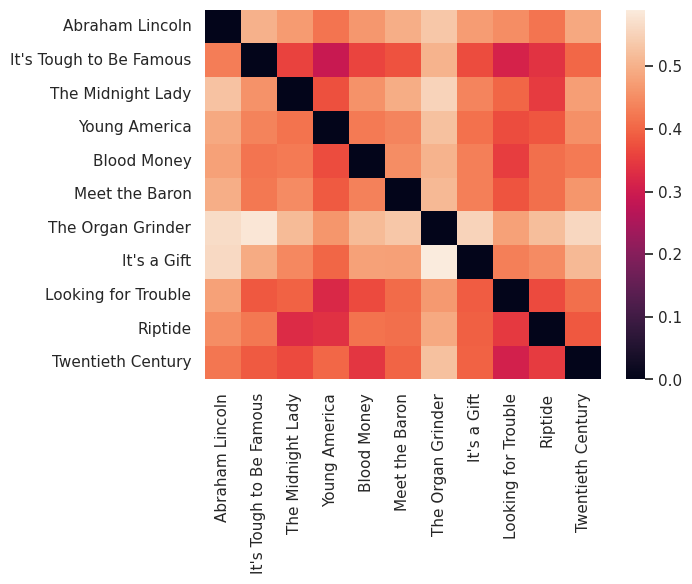

In [ ]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()


To reveal more patterns, let's do a multidimensional scaling of the matrix.

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


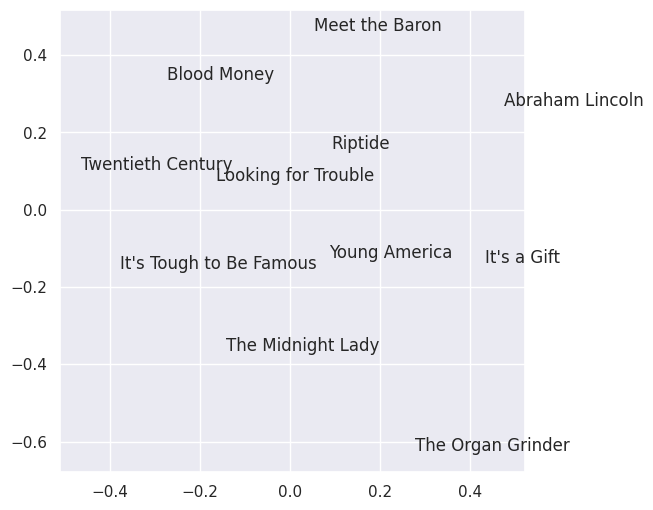

In [ ]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

A co-respondent's course and The Chain Gang are away from the others - any guesses why?

We may just want to focus on the distrbution of stopwords or non-stopwords. Let's do the analysis again first for stopwords and then for non-stopwords.

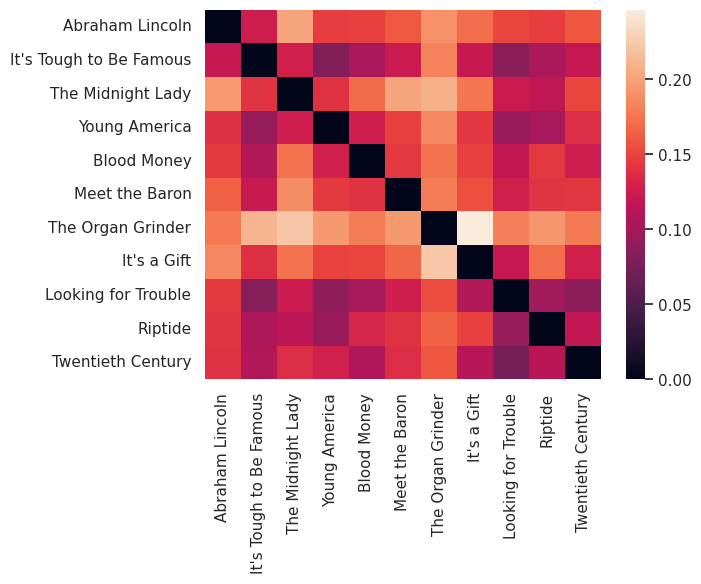

In [ ]:
L = []
for p in corpora_s:
    l = []
    for q in corpora_s:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

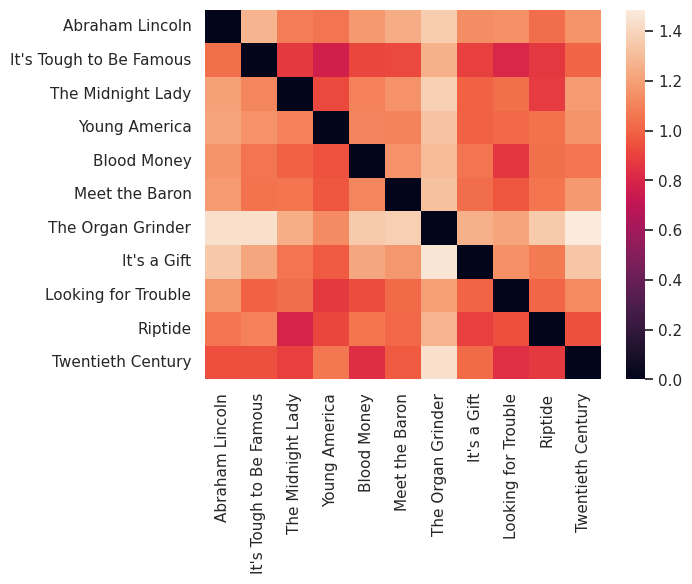

In [ ]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

For the KS distance:

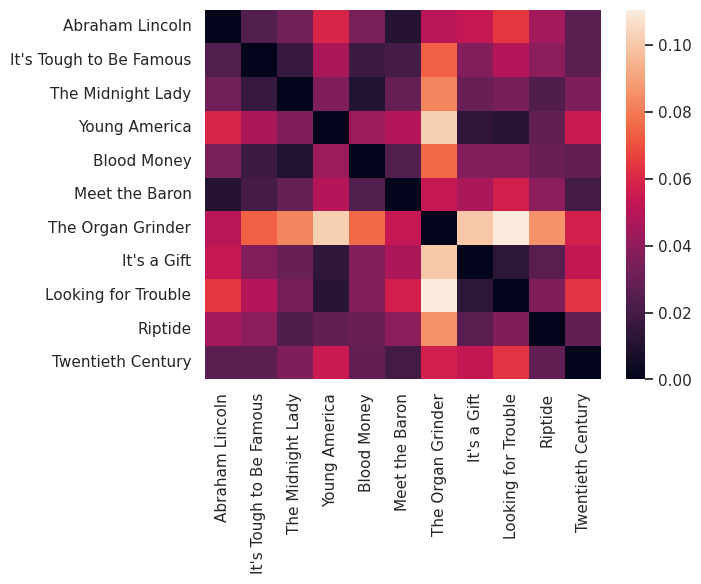

In [ ]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

And finally for the Wasserstein or "earth mover's" Distance.

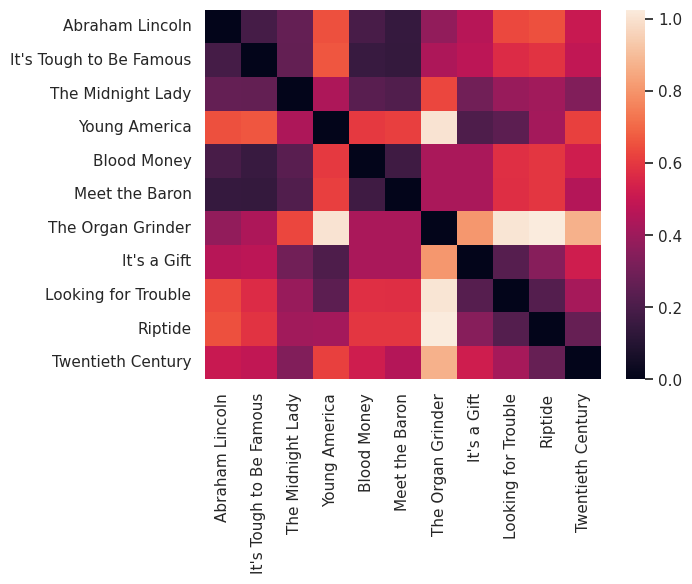

In [ ]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

You can see that decade X is highly divergent and this makes reading the plot somewhat difficult. Let's fix this by taking the log of each cell, which will reduce the distance of decode X from other texts as an outlier.

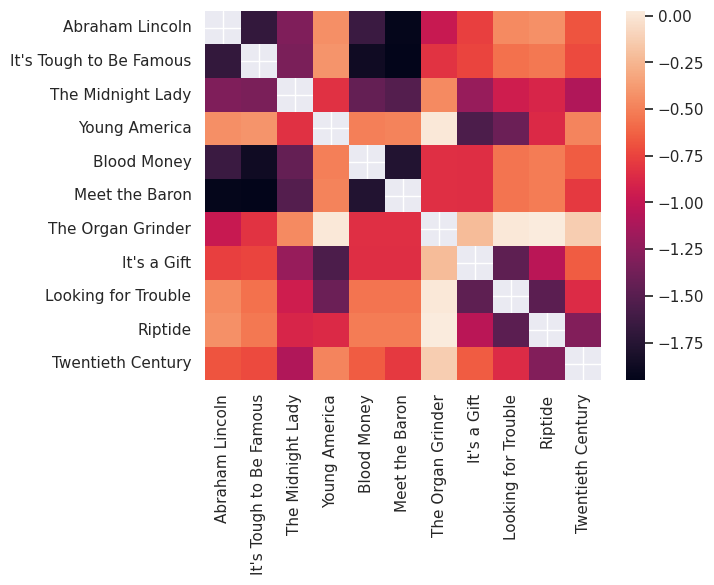

In [ ]:
ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.show()

We only tried 11 movies, and from the same time period, so our signals might not be too interesting. What about different time periods?

An interesting experiment to maybe get some clearer signals: documents by decade in the Davies Corpus Of Historial American English (COHA) and see if we can detect patterns between them.

If we want to rerun this on a new data set of our own composition, we can be a bit more efficient with our coding. Let's use the Shakespeare texts from last week as example. Here we again make use of our convenient `lucem_illud` functions, namely `loadTextDirectory`, which is found in [loaders.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/loaders.py).

In [ ]:
def loadTextDirectory(targetDir, encoding = 'utf-8'):
    text = []
    fileName = []

    for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
        with open(file.path, encoding = encoding) as f:
            text.append(f.read())
        fileName.append(file.name)
    return pandas.DataFrame({'text' : text}, index = fileName)

In [ ]:
shakespeare_df = lucem_illud.loadTextDirectory('../data/Shakespeare')

Now we stem and remove stopwords

In [ ]:
shakespeare_df['tokenized_text'] = shakespeare_df['text'].apply(lambda x: word_tokenize(x))
shakespeare_df['normalized_tokens'] = shakespeare_df['tokenized_text'].apply(lambda x: normalizeTokens(x))

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Create the corpus file and generate the heatmap:

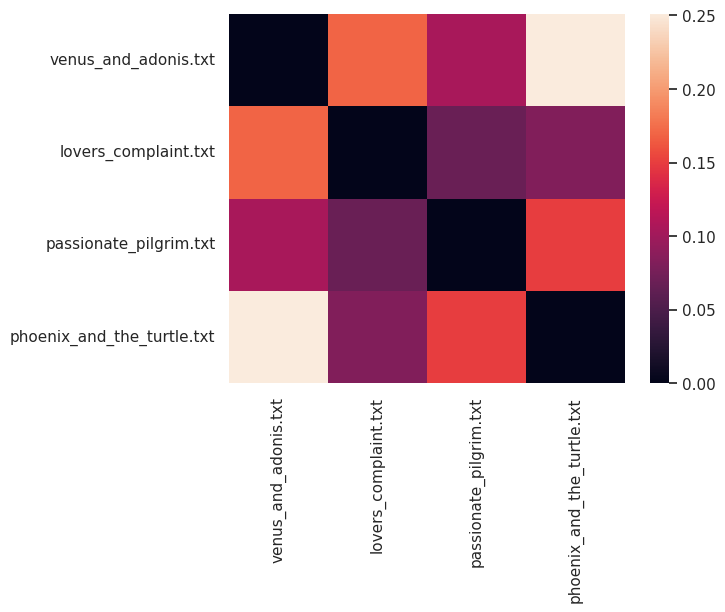

In [ ]:
measure = 'KS' #"KL", "Chi2", "KS", "Wasserstein"
num_of_texts = 10 #The bigger this number the slower it will run, you can also try selecting your own plays
fileids_sp = list(shakespeare_df[:num_of_texts].index)
corpora_sp = list(shakespeare_df[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

What are "The Passionate Pilgrim" and "The Phoenix and the Turtle"? Little known poems by Shakespeare that are unsurprisingly hard to classify, as they are so different from everything else he wrote.

## <font color="red">*Exercise 7*</font>

<font color="red">Construct cells immediately below this that calculate the KL and $\chi^2$ divergences, and the KS and Wasserstein distances between four separate corpora, plot these with heatmaps, and then array them in two dimensions with multidimensional scaling as above. What does this reveal about relations between the corpora? Which analysis (and divergence or distribution) distinguishes the authors or documents better?

**Stretch**: Calculate the [Jensen-Shannon Divergence](https://en.wikipedia.org/wiki/Jensen–Shannon_divergence) between your four corpora. What is the relationship between the KL and JS divergences?</font>

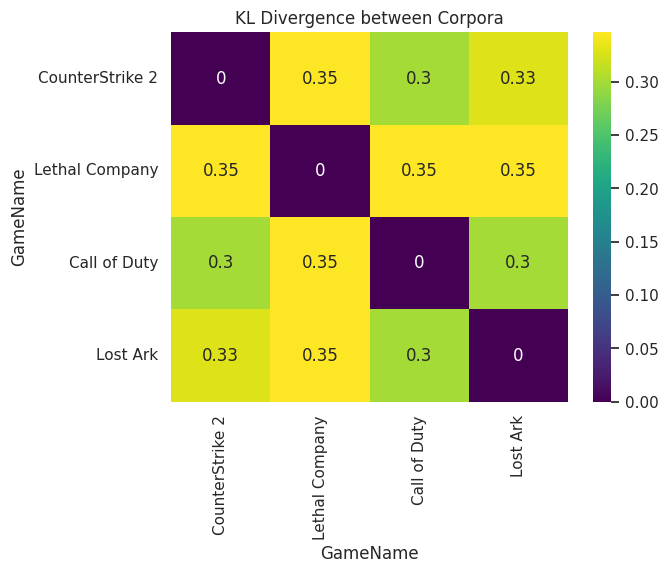

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


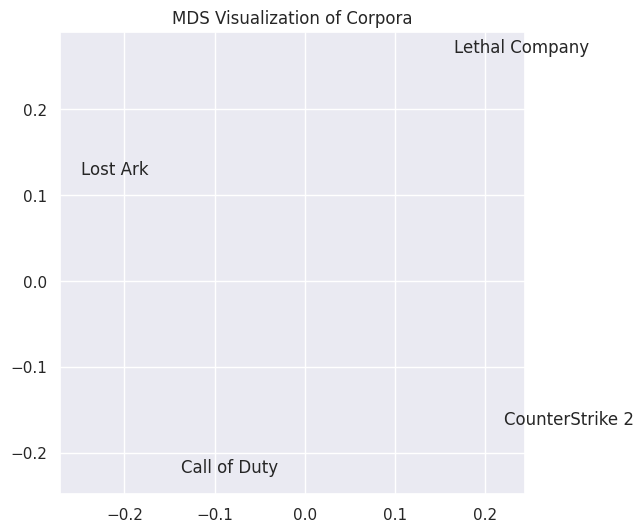

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

def kl_divergence(X, Y):
    P = pd.Series(X).value_counts(normalize=True).sort_index()
    Q = pd.Series(Y).value_counts(normalize=True).sort_index()
    D_kl = np.sum(np.abs(P - Q) * np.log(P / Q))
    return D_kl

def chi2_divergence(X, Y):
    P = pd.Series(X).value_counts().sort_index()
    Q = pd.Series(Y).value_counts().sort_index()
    return np.sum((P - Q)**2 / Q)

def Divergence(corpus1, corpus2, difference="KL"):
    min_size = min(len(corpus1), len(corpus2))
    combined_corpus = corpus1[:min_size] + corpus2[:min_size]
    if difference == "KL":
        return kl_divergence(corpus1[:min_size], combined_corpus)
    elif difference == "Chi2":
        return chi2_divergence(corpus1[:min_size], combined_corpus)

# Define corpora
corpus1 = reviews_df["NormalizedReviews"].iloc[1][4]
corpus2 = reviews_df["NormalizedReviews"].iloc[2][4]
corpus3 = reviews_df["NormalizedReviews"].iloc[3][4]
corpus4 = reviews_df["NormalizedReviews"].iloc[4][4]

# Extract game names from the "GameName" column
game_names = reviews_df.loc[1:4, "GameName"]

# Use Divergence function to calculate divergences
divergences = pd.DataFrame(index=game_names, columns=game_names)

for i, game1 in enumerate(game_names):
    for j, game2 in enumerate(game_names):
        if i != j:
            divergence = Divergence(eval(f"corpus{i + 1}"), eval(f"corpus{j + 1}"), difference="KL")
            divergences.loc[game1, game2] = divergence

# Fill NaN values with zeros
divergences = divergences.fillna(0)

# Visualize KL Divergence with a heatmap
sns.heatmap(divergences.astype(float), annot=True, cmap="viridis", xticklabels=game_names, yticklabels=game_names)
plt.title('KL Divergence between Corpora')
plt.show()

# Use Multidimensional Scaling (MDS) for visualization
mds = MDS()
pos = mds.fit_transform(divergences)

# Plot the MDS visualization
x = pos[:, 0]
y = pos[:, 1]
fig, ax = plt.subplots(figsize=(6, 6))
plt.plot(x, y, ' ')
for i, game in enumerate(game_names):
    ax.annotate(f"{game}", (x[i], y[i]))

plt.title('MDS Visualization of Corpora')
plt.show()

**There appears to be a lot of homogeneity in the corpora, so neither analysis is too useful, though the KL Divergence does offer a clearer (and prettier) picture of the similarities and (slight) differences.**

Now, taking a subset of the corpora to see whether that changes things (more or less as a sanity check).

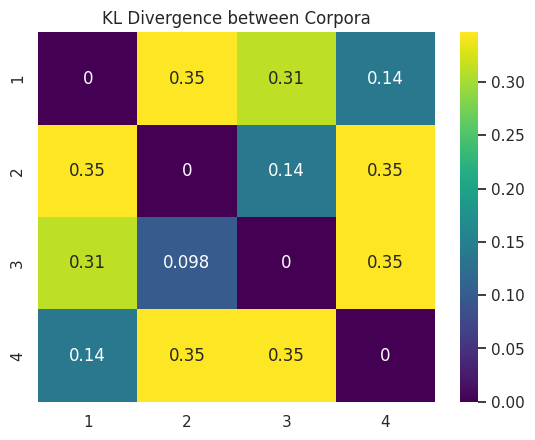

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


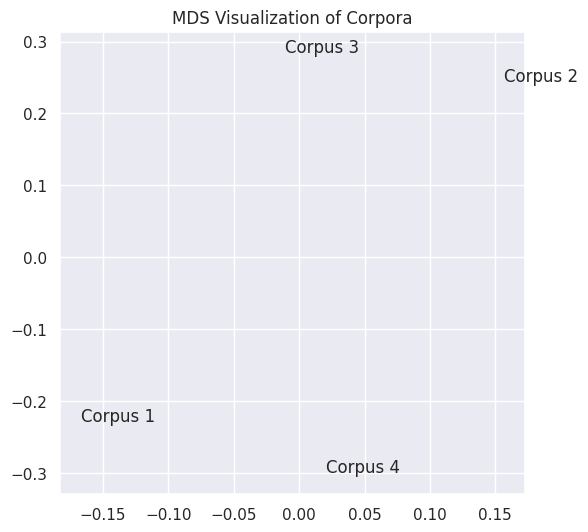

In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import random

# Set a random seed for reproducibility
random.seed(42)

def kl_divergence(X, Y):
    P = pd.Series(X).value_counts(normalize=True).sort_index()
    Q = pd.Series(Y).value_counts(normalize=True).sort_index()
    D_kl = np.sum(np.abs(P - Q) * np.log(P / Q))
    return D_kl

def chi2_divergence(X, Y):
    P = pd.Series(X).value_counts().sort_index()
    Q = pd.Series(Y).value_counts().sort_index()
    return np.sum((P - Q)**2 / Q)

def Divergence(corpus1, corpus2, difference="KL"):
    min_size = min(len(corpus1), len(corpus2))
    combined_corpus = corpus1[:min_size] + corpus2[:min_size]
    if difference == "KL":
        return kl_divergence(corpus1[:min_size], combined_corpus)
    elif difference == "Chi2":
        return chi2_divergence(corpus1[:min_size], combined_corpus)

# Define corpora
corpus1 = random.sample(reviews_df["NormalizedReviews"].iloc[2][3], 10)
corpus2 = random.choices(reviews_df["NormalizedReviews"].iloc[2][2], k=10)
corpus3 = random.sample(reviews_df["NormalizedReviews"].iloc[2][2], 10)
corpus4 = random.sample(reviews_df["NormalizedReviews"].iloc[2][3], 10)

# Use Divergence function to calculate divergences
divergences = pd.DataFrame(index=range(1, 5), columns=range(1, 5))

for i in range(1, 5):
    for j in range(1, 5):
        if i != j:
            divergence = Divergence(eval(f"corpus{i}"), eval(f"corpus{j}"), difference="KL")
            divergences.iloc[i - 1, j - 1] = divergence

# Fill NaN values with zeros
divergences = divergences.fillna(0)

# Visualize KL Divergence with a heatmap
sns.heatmap(divergences.astype(float), annot=True, cmap="viridis", xticklabels=range(1, 5), yticklabels=range(1, 5))
plt.title('KL Divergence between Corpora')
plt.show()

# Use Multidimensional Scaling (MDS) for visualization
mds = MDS()
pos = mds.fit_transform(divergences)

# Plot the MDS visualization
x = pos[:, 0]
y = pos[:, 1]
fig, ax = plt.subplots(figsize=(6, 6))
plt.plot(x, y, ' ')
for i, txt in enumerate(range(1, 5)):
    ax.annotate(f"Corpus {txt}", (x[i], y[i]))

plt.title('MDS Visualization of Corpora')
plt.show()

**Again, there appears to be a lot of homogeneity in the corpora even with a subset, so neither analysis is too useful, though the KL Divergence does a better job showing the divergence.**